In [ ]:
import yfinance as yf
import pandas as pd
import plotly.express as px

# Define the tickers
tickers = {
    'Bitcoin': 'btc-USD',
}

""" tickers = {
    'SPY': 'SPY',        # SPDR S&P 500 ETF Trust
    'Apple': 'AAPL',     # Apple Inc.
    'NVIDIA': 'NVDA',    # NVIDIA Corporation
    'Tesla': 'TSLA',     # Tesla Inc.
    'Bitcoin': 'btc-USD', # Bitcoin
    # Additional popular tickers
    'Amazon': 'AMZN',    # Amazon.com, Inc.
    'Google': 'GOOGL',   # Alphabet Inc. (Class A)
    'Microsoft': 'MSFT', # Microsoft Corporation
    'Meta': 'META',      # Meta Platforms, Inc.
} """

# Download historical data for the tickers
data = yf.download(
    tickers=list(tickers.values()),
    period='max',       # Adjust the period as needed # Adjust the period as needed '6mo' '1d' 'max'
    interval='1d',     # Data interval Data interval '1m' '1h' '1d'       #best is w max and 1d so far
    group_by='ticker',
    auto_adjust=True,
    threads=True
)

print(data)

btc = data

#Flattening the multi-level columns
btc.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in btc.columns]
ticker_prefix = btc.columns[0].split('_')[0]

# Renaming the columns to remove prefixes and simplify names
new_column_names = {
    f'{ticker_prefix}_Open': 'Open',
    f'{ticker_prefix}_High': 'High',
    f'{ticker_prefix}_Low': 'Low',
    f'{ticker_prefix}_Close': 'Close',
    f'{ticker_prefix}_Volume': 'Volume'
}
btc.rename(columns=new_column_names, inplace=True)

# Reset the index, which moves the date from the index to a column
btc.reset_index(inplace=True)

print(btc)

# Step 1: Extract Bitcoin Volume before dropping columns
print(btc['Volume'].eq(0).sum())
print(btc)
print(btc.describe())
# Count NaNs in each column
na_counts = btc.isna().sum()

# Display the count of NaNs for each column
print(na_counts)


In [ ]:
if 'Datetime' in btc.columns:
    btc.rename(columns={'Datetime': 'Date'}, inplace=True)
    btc = btc.drop(columns="Volume")

print(btc)

# Perform min-max normalization for each asset
normalized_prices = btc.copy() #closed_prices, crypto_df, non_crypto_df, btc, compiled

# Exclude the 'Date' column during normalization
for col in normalized_prices.columns[1:]:
    min_price = normalized_prices[col].min()
    max_price = normalized_prices[col].max()
    normalized_prices[col] = ((normalized_prices[col] - min_price) / (max_price - min_price)) * 100

# Melt the DataFrame to long format
normalized_prices_melted = normalized_prices.melt(id_vars='Date', var_name='Asset', value_name='Normalized Price')

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each asset's normalized prices
for asset, data in normalized_prices_melted.groupby('Asset'):
    ax.plot(data['Date'], data['Normalized Price'], label=asset)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price (0% = Min, 100% = Max)')
ax.set_title('Min-Max Normalized Closing Prices for Selected Assets Over Time')
ax.legend()

# Show the plot
plt.show()

print(btc)

In [ ]:
import pandas as pd
import os

def clean_sentiment_score(score):
    """Remove leading single quote from sentiment score if present"""
    if isinstance(score, str) and score.startswith("'"):
        return float(score.lstrip("'"))
    return float(score)

# Read the sentiment file
file_path = os.path.join(os.path.expanduser('~'), 'Downloads', 'combined_crypto_analysis.csv')
sentiment_df = pd.read_csv(file_path)

# Process and merge the data
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.tz_localize('UTC')
sentiment_df['sentiment_score'] = sentiment_df['avg_sentiment'].apply(clean_sentiment_score)
btc['Date'] = pd.to_datetime(btc['Date'])

# Merge and update btc DataFrame
btc = btc.merge(sentiment_df[['Date', 'sentiment_score']], on='Date', how='left')

print(f"Merged shape: {btc.shape}, Rows with sentiment: {btc['sentiment_score'].notna().sum()}")

btc
              Open          High           Low     Close       Volume  \
0       456.859985    456.859985    413.104004 -7.192558     34483200   
1       424.102997    427.834991    384.532013 -6.984265     37919700   
2       394.673004    423.295990    389.882996  3.573492     36863600   
3       408.084991    412.425995    393.181000 -2.465854     26580100   
4       399.100006    406.915985    397.130005  0.835210     24127600   
...            ...           ...           ...       ...          ...   
3723  91978.140625  97361.179688  91778.664062  4.323745  71133452438   
3724  95954.945312  96650.203125  94677.351562 -0.323108  52260008261   
3725  95653.953125  98693.171875  95407.882812  1.891279  54968682476   
3726  97468.812500  97499.343750  96144.218750 -1.038839  31634227866   
3727  96461.335938  97888.125000  95770.187500  0.861319  36590695296   

      sentiment_score    Close_True  
0           -2.274216    424.440002  
1           -1.657459    394.795990  
2    

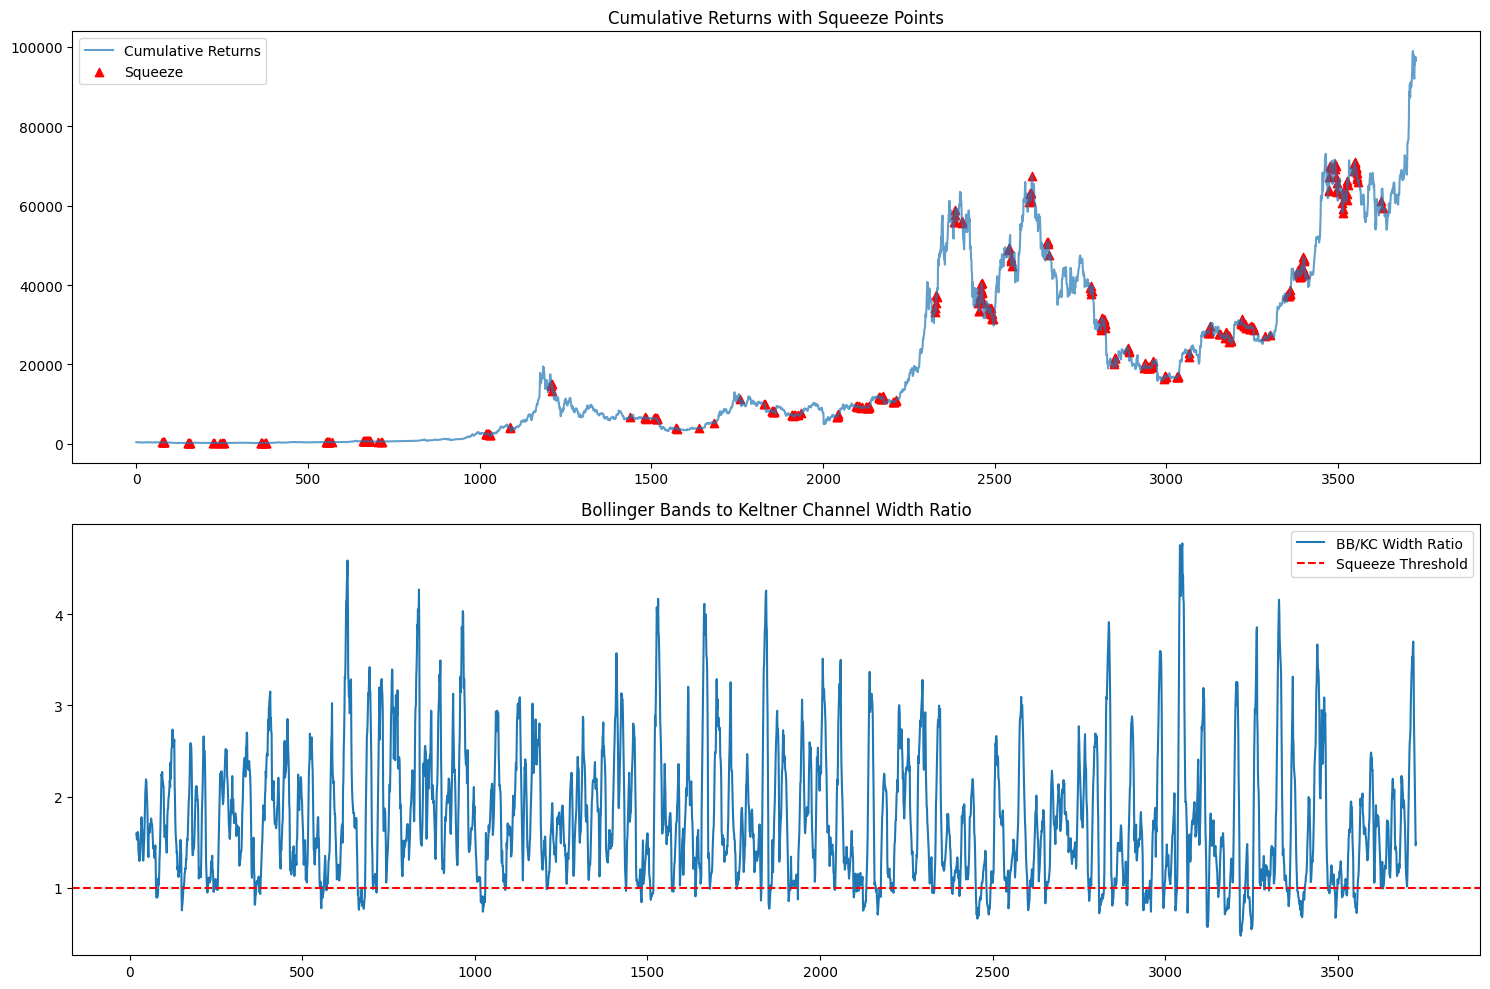

count     3709.000000
mean      4297.664753
std       5582.674845
min         10.679233
25%        319.551435
50%       2065.746485
75%       6488.964456
max      39268.288731
Name: BB_width, dtype: float64
count     3709.000000
mean      2609.823380
std       3135.504471
min          9.846689
25%        187.898466
50%       1155.763658
75%       4109.488691
max      16079.761631
Name: KC_width, dtype: float64
count    3709.000000
mean        1.754004
std         0.721469
min         0.473087
25%         1.187568
50%         1.606496
75%         2.174062
max         4.776663
Name: BB_KC_ratio, dtype: float64
First few values of cumulative_returns:
3723    95962.531250
3724    95652.468750
3725    97461.523438
3726    96449.054688
3727    97279.789062
Name: Close_True, dtype: float64
First few values of cumulative_high:
3723    97361.179688
3724    96650.203125
3725    98693.171875
3726    97499.343750
3727    97888.125000
Name: High, dtype: float64
First few values of cumulative_low:
3

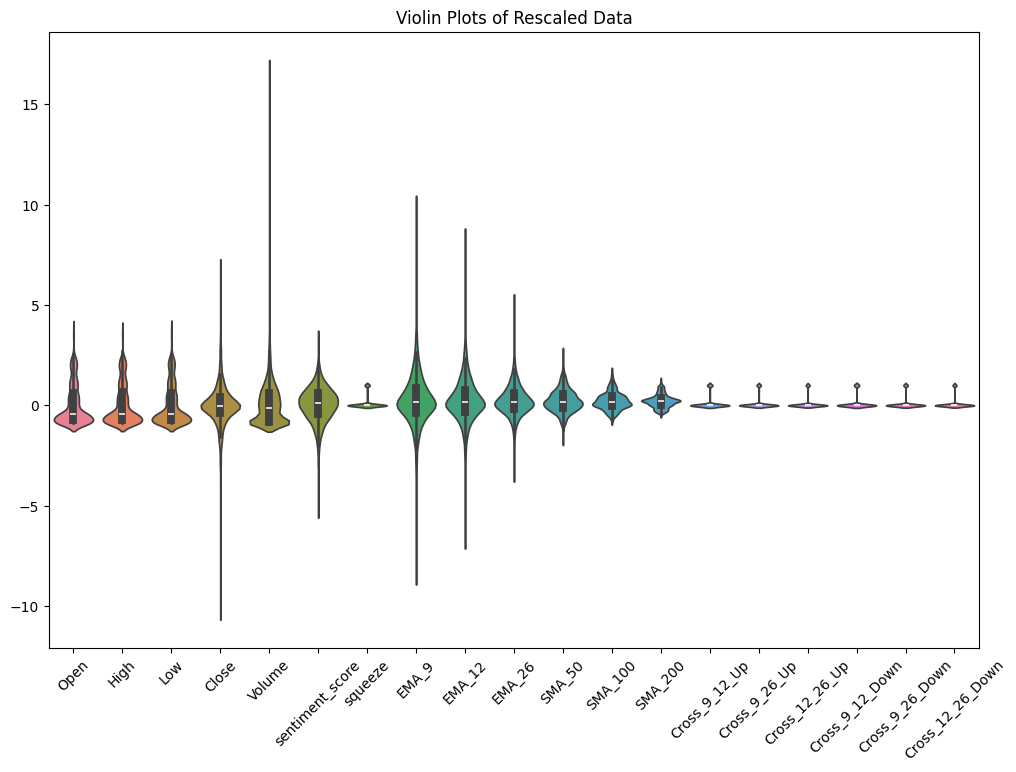

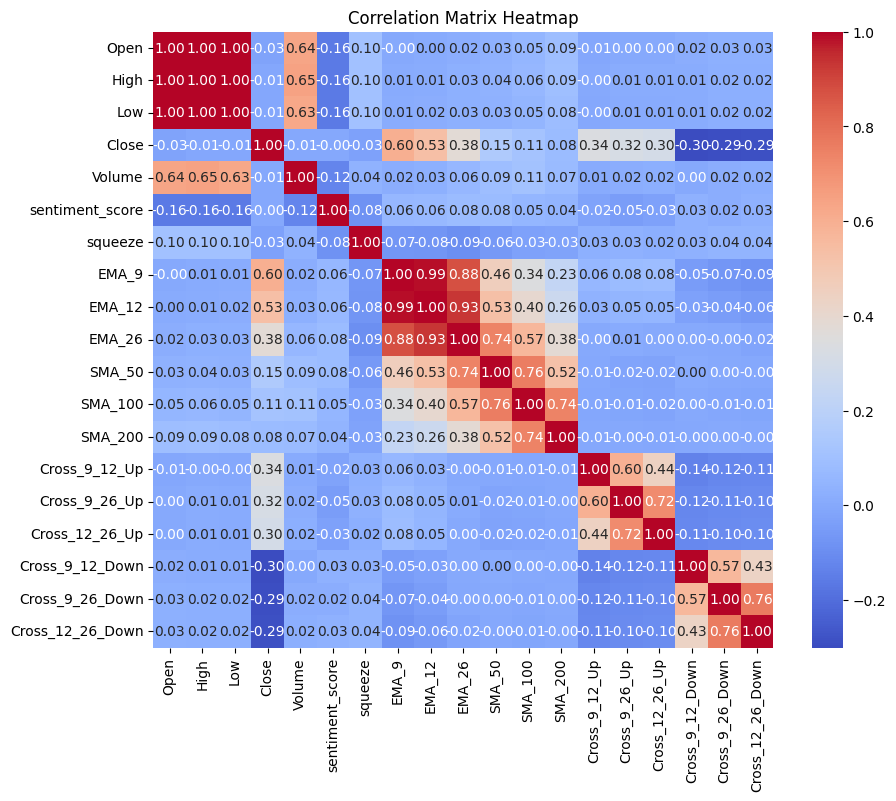

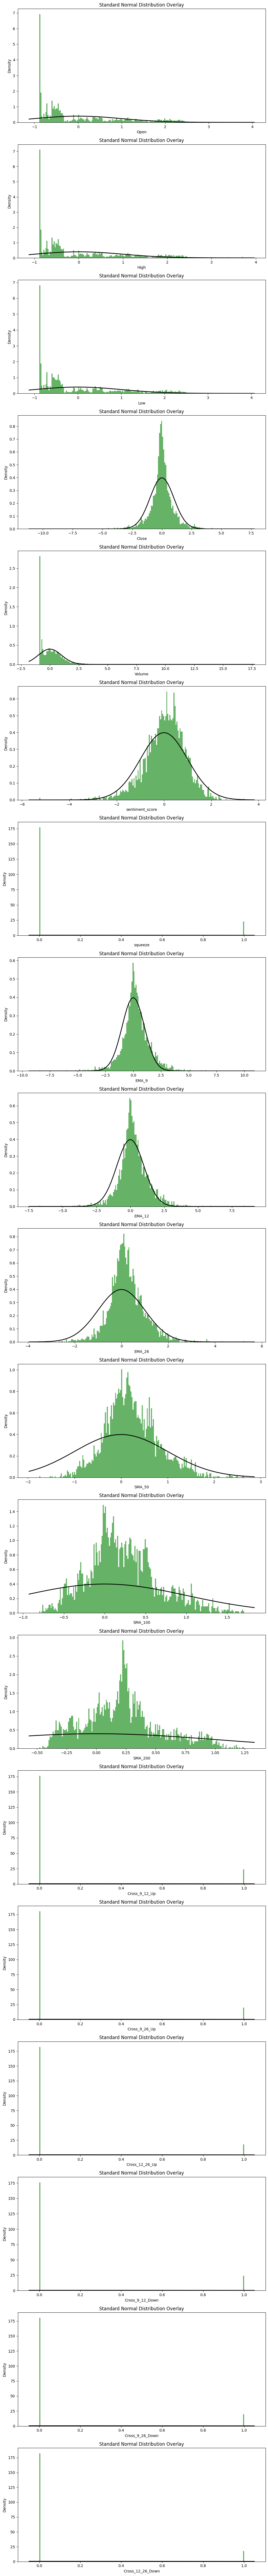

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Converts Close to Percentage ################################################################################
btc["Close_True"] = btc['Close']
btc['Close'] = btc['Close'].pct_change() * 100
btc = btc.dropna().reset_index(drop=True)

def global_rescale(data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    if std_val == 0:
        rescaled_data = np.zeros_like(data)
    else:
        rescaled_data = (data - mean_val) / std_val
    return rescaled_data

if 'Date' in btc.columns:
    btc = btc.drop(columns='Date')
# Apply the global_rescale function to each column
rescaled_data = btc.apply(global_rescale) 

print("btc")
print(btc)
print("rescaled_data")
print(rescaled_data)

# Calculate EMA for ATR
def calculate_ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

# Parameters
bb_length = 20
bb_std_dev = 2
kc_length = 20
kc_multiplier = 1.5

# Convert percentage changes back to price-like series for calculations
cumulative_returns = btc['Close_True']
cumulative_high = btc['High']
cumulative_low = btc['Low']

# Calculate Bollinger Bands on the cumulative series
sma = cumulative_returns.rolling(window=bb_length).mean()
std = cumulative_returns.rolling(window=bb_length).std()
bb_upper = sma + (bb_std_dev * std)
bb_lower = sma - (bb_std_dev * std)

# Calculate True Range using cumulative values
tr1 = cumulative_high - cumulative_low
tr2 = abs(cumulative_high - cumulative_returns.shift(1))
tr3 = abs(cumulative_low - cumulative_returns.shift(1))
true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

# Calculate ATR using EMA
atr = calculate_ema(true_range, kc_length)

# Calculate Keltner Channels
kc_upper = sma + (kc_multiplier * atr)
kc_lower = sma - (kc_multiplier * atr)

# Calculate TTM Squeeze
squeeze = np.where(
    (bb_upper < kc_upper) & (bb_lower > kc_lower),
    1,  # Squeeze is on
    0   # Squeeze is off
)

# Calculate Momentum
highest_high = cumulative_high.rolling(window=bb_length).max()
lowest_low = cumulative_low.rolling(window=bb_length).min()
avg_hl = (highest_high + lowest_low) / 2
avg_hlc = (avg_hl + cumulative_returns) / 2
momentum = cumulative_returns - avg_hlc

# Store calculations
btc['squeeze'] = squeeze
rescaled_data['squeeze'] = squeeze
btc['momentum'] = momentum
btc['BB_upper'] = bb_upper
btc['BB_lower'] = bb_lower
btc['KC_upper'] = kc_upper
btc['KC_lower'] = kc_lower
btc['BB_width'] = bb_upper - bb_lower
btc['KC_width'] = kc_upper - kc_lower
btc['BB_KC_ratio'] = (bb_upper - bb_lower) / (kc_upper - kc_lower)

# Print statistics
print("\nBand Width Statistics:")
print("\nBollinger Band Width:")
print(btc['BB_width'].describe())
print("\nKeltner Channel Width:")
print(btc['KC_width'].describe())
print("\nSqueeze Statistics:")
print(f"Total periods: {len(btc)}")
print(f"Number of squeeze periods: {btc['squeeze'].sum()}")
print(f"Percentage of time in squeeze: {(btc['squeeze'].sum() / len(btc) * 100):.2f}%")

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Price with squeeze points
plt.subplot(2, 1, 1)
plt.plot(btc.index, cumulative_returns, label='Cumulative Returns', alpha=0.7)
squeeze_points = btc[btc['squeeze'] == 1].index
plt.scatter(squeeze_points,
           cumulative_returns[squeeze_points],
           color='red', marker='^', label='Squeeze')
plt.title('Cumulative Returns with Squeeze Points')
plt.legend()

# Plot 2: BB/KC Width Ratio
plt.subplot(2, 1, 2)
plt.plot(btc.index, btc['BB_KC_ratio'], label='BB/KC Width Ratio')
plt.axhline(y=1, color='r', linestyle='--', label='Squeeze Threshold')
plt.title('Bollinger Bands to Keltner Channel Width Ratio')
plt.legend()

plt.tight_layout()
plt.show()

print(btc['BB_width'].describe())
print(btc['KC_width'].describe())
print(btc['BB_KC_ratio'].describe())

# Print initial values to check scales and consistency
print("First few values of cumulative_returns:")
print(cumulative_returns.tail())

print("First few values of cumulative_high:")
print(cumulative_high.tail())

print("First few values of cumulative_low:")
print(cumulative_low.tail())

# After calculating True Range and ATR
print("\nFirst few values of True Range (TR):")
print(tr1.tail(), tr2.tail(), tr3.tail())

print("\nFirst few values of Average True Range (ATR):")
print(atr.tail())

# After calculating Bollinger Bands
print("\nFirst few values of SMA for Bollinger Bands:")
print(sma.tail())

print("\nFirst few values of Bollinger Bands Upper and Lower:")
print("BB Upper:", bb_upper.tail())
print("BB Lower:", bb_lower.tail())

# After calculating Keltner Channels
print("\nFirst few values of Keltner Channels Upper and Lower:")
print("KC Upper:", kc_upper.tail())
print("KC Lower:", kc_lower.tail())

# After calculating Widths
print("\nBollinger Band Width:")
print(btc['BB_width'].tail())

print("\nKeltner Channel Width:")
print(btc['KC_width'].tail())

# Print ratios and squeeze information
print("\nFirst few values of BB/KC Width Ratio:")
print(btc['BB_KC_ratio'].tail())

print("\nSqueeze Statistics:")
print("First few periods of squeeze signal:")
print(btc['squeeze'].tail())

rescaled_data.drop(columns=['Close_True'], inplace=True)

# Calculate EMAs and SMAs on the raw price data
price_emas = {
    'EMA_9': btc['Close'].ewm(span=9, adjust=False).mean(),
    'EMA_12': btc['Close'].ewm(span=12, adjust=False).mean(),
    'EMA_26': btc['Close'].ewm(span=26, adjust=False).mean(),
    'SMA_50': btc['Close'].rolling(window=50).mean(),
    'SMA_100': btc['Close'].rolling(window=100).mean(),
    'SMA_200': btc['Close'].rolling(window=200).mean()
}

# Calculate percentage-based EMAs and SMAs
rescaled_data['EMA_9'] = btc['Close'].ewm(span=9, adjust=False).mean()
rescaled_data['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean()
rescaled_data['EMA_26'] = btc['Close'].ewm(span=26, adjust=False).mean()
rescaled_data['SMA_50'] = btc['Close'].rolling(window=50).mean()
rescaled_data['SMA_100'] = btc['Close'].rolling(window=100).mean()
rescaled_data['SMA_200'] = btc['Close'].rolling(window=200).mean()

# Detect upward crossovers
rescaled_data['Cross_9_12_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Up'] = ((rescaled_data['EMA_12'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)

# Detect downward crossovers
rescaled_data['Cross_9_12_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Down'] = ((rescaled_data['EMA_12'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)

# Drop all NaN values and reset index
rescaled_data.dropna(inplace=True)
rescaled_data.reset_index(drop=True, inplace=True)

print("Rescaled Data:")
print(rescaled_data)

# Compute basic statistics for each column
stats = rescaled_data.describe()

# Print the statistics
print("\nBasic Statistical Summary:")
print(stats)

# Plot violin plots for each column
plt.figure(figsize=(12, 8))
sns.violinplot(data=rescaled_data)
plt.title('Violin Plots of Rescaled Data')
plt.xticks(rotation=45)
plt.show()

# Compute the correlation matrix
corr_matrix = rescaled_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot histograms with a standard normal distribution overlay for each column
fig, axes = plt.subplots(nrows=len(rescaled_data.columns), ncols=1, figsize=(10, 5 * len(rescaled_data.columns)))
if len(rescaled_data.columns) == 1:
    axes = [axes]  # Ensure axes is iterable for a single-column dataframe

for ax, column in zip(axes, rescaled_data.columns):
    data = rescaled_data[column].dropna()  # Drop NA values

    # Define the number of bins to make them smaller
    bins = 200

    # Plot histogram
    ax.hist(data, bins=bins, density=True, alpha=0.6, color='g')

    # Define the range of x values for the normal distribution line
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    # Calculate the standard normal distribution
    p = norm.pdf(x, 0, 1)  # Mean = 0, Std = 1
    ax.plot(x, p, 'k', linewidth=2)

    ax.set_title(f"Standard Normal Distribution Overlay")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
import warnings
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import pandas as pd
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
from skorch.callbacks import EarlyStopping, LRScheduler
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.dataset import Dataset
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ks_2samp
from tqdm import tqdm
import time
from skorch.callbacks import Callback
import torch.nn.functional as F

class ProgressCallback(Callback):
    def __init__(self, total_epochs, desc="Training"):
        self.pbar = None
        self.total_epochs = total_epochs
        self.desc = desc

    def on_train_begin(self, net, X=None, y=None, **kwargs):
        # Close any existing progress bar
        if self.pbar is not None:
            self.pbar.close()
        self.pbar = tqdm(total=self.total_epochs, desc=self.desc, leave=False)

    def on_epoch_end(self, net, **kwargs):
        if self.pbar is not None:
            self.pbar.update(1)

    def on_train_end(self, net, X=None, y=None, **kwargs):
        if self.pbar is not None:
            self.pbar.close()
            self.pbar = None

class PrintLossCallback(Callback):
    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        train_loss = net.history[-1, 'train_loss']
        valid_loss = net.history[-1, 'valid_loss']
        epoch = len(net.history)
        print(f'Epoch: {epoch:4d} | Train Loss: {train_loss:.6f} | Valid Loss: {valid_loss:.6f}')

class NoSmallLoss(nn.Module):
    def __init__(self, lower_bound=-0.5, upper_bound=0.5, penalty_weight=1.0):
        super().__init__()
        self.base_criterion = nn.MSELoss()
        self.penalty_weight = penalty_weight
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.last_base_loss = 0
        self.last_penalty = 0

    def forward(self, pred, target):
        # Calculate base MSE loss
        base_loss = self.base_criterion(pred, target)

        # Create mask for targets outside the bounds
        target_outside_bounds = (target < self.lower_bound) | (target > self.upper_bound)
        pred_in_bounds = (pred > self.lower_bound) & (pred < self.upper_bound)

        # Only apply penalty when:
        # 1. Target is outside bounds AND
        # 2. Prediction is inside bounds
        should_penalize = target_outside_bounds & pred_in_bounds

        # Calculate the appropriate penalty based on target direction
        penalty = torch.where(
            target > self.upper_bound,
            F.relu(self.upper_bound - pred) * should_penalize.float(),  # Push up for high targets
            torch.where(
                target < self.lower_bound,
                F.relu(pred - self.lower_bound) * should_penalize.float(),  # Push down for low targets
                torch.zeros_like(pred)  # No penalty if target is within bounds
            )
        )

        # Apply penalty and normalize by batch size
        penalty = (penalty ** 2).mean() * self.penalty_weight

        total_loss = base_loss + penalty

        # Store components for monitoring
        with torch.no_grad():
            self.last_base_loss = base_loss.item()
            self.last_penalty = penalty.item()
            small_pred_ratio = torch.sum(pred_in_bounds.float()) / pred.numel()
            penalty_ratio = penalty / (base_loss + 1e-8)
            target_in_bounds_ratio = torch.sum((~target_outside_bounds).float()) / target.numel()
            self.small_pred_ratio = small_pred_ratio
            self.penalty_ratio = penalty_ratio
            self.target_in_bounds_ratio = target_in_bounds_ratio

        return total_loss

class TrialPruningCallback(Callback):
    def __init__(self, threshold_loss=30000.0, min_epochs=10, max_bad_epochs=5):
        self.threshold_loss = threshold_loss
        self.min_epochs = min_epochs
        self.max_bad_epochs = max_bad_epochs
        self.bad_epochs = 0

    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        epoch = len(net.history)
        # Get the valid_loss which is NoSmallLoss output (MSE + penalty)
        current_loss = net.history[-1, 'valid_loss']

        # Only start checking after min_epochs
        if epoch >= self.min_epochs:

            if current_loss > self.threshold_loss:
                self.bad_epochs += 1
                print(f"\nWarning: Loss {current_loss:.2f} above threshold {self.threshold_loss:.2f}. "
                      f"Bad epochs: {self.bad_epochs}/{self.max_bad_epochs}")
            else:
                self.bad_epochs = 0

            if self.bad_epochs >= self.max_bad_epochs:
                print(f"\nPruning trial - Loss above {self.threshold_loss:.2f} for {self.max_bad_epochs} epochs")
                raise KeyboardInterrupt(f"Trial pruned - Loss above {self.threshold_loss:.2f} for {self.max_bad_epochs} epochs")

# 1. Data Splitting Configuration
test_size = 0.2
val_size = 0.2
eval_size = 0.1

def prepare_train_test_splits(data, target_col):
    """Prepare train, validation, eval, and test splits while maintaining temporal order"""
    total_size = len(data)
    test_split_idx = int(total_size * (1 - test_size))
    val_split_idx = int(test_split_idx * (1 - val_size - eval_size))
    eval_split_idx = int(test_split_idx * (1 - eval_size))

    splits = {
        'train': {
            'X': data.iloc[:val_split_idx, :],
            'y': data[target_col][:val_split_idx]
        },
        'eval': {
            'X': data.iloc[val_split_idx:eval_split_idx, :],
            'y': data[target_col][val_split_idx:eval_split_idx]
        },
        'val': {
            'X': data.iloc[eval_split_idx:test_split_idx, :],
            'y': data[target_col][eval_split_idx:test_split_idx]
        },
        'test': {
            'X': data.iloc[test_split_idx:, :],
            'y': data[target_col][test_split_idx:]
        }
    }
    return splits

def evaluate_model_with_distribution(model, X_test_seq, y_test_seq, train_distribution, history=None):
    """Enhanced model evaluation including distribution comparison"""
    # Get predictions
    y_pred_test = model.predict(X_test_seq)

    # Calculate metrics
    test_mse = mean_squared_error(y_test_seq, y_pred_test)
    test_r2 = r2_score(y_test_seq, y_pred_test)

    # Flatten arrays before KS test
    train_dist_flat = train_distribution.flatten()
    pred_dist_flat = y_pred_test.flatten()

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = ks_2samp(train_dist_flat, pred_dist_flat)

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Prediction scatter plot
    axes[0,0].scatter(y_test_seq, y_pred_test, alpha=0.5)
    axes[0,0].plot([y_test_seq.min(), y_test_seq.max()],
                   [y_test_seq.min(), y_test_seq.max()],
                   'k--', lw=3)
    axes[0,0].set_title('Predicted vs. True Values')
    axes[0,0].set_xlabel('True Values')
    axes[0,0].set_ylabel('Predicted Values')
    axes[0,0].grid(True)

    # Distribution comparison
    axes[0,1].hist(train_dist_flat, bins=50, alpha=0.5, density=True, label='Training')
    axes[0,1].hist(pred_dist_flat, bins=50, alpha=0.5, density=True, label='Predictions')
    axes[0,1].set_title(f'Distribution Comparison\nKS test: stat={ks_statistic:.3f}, p={p_value:.3f}')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves
    if history:
        train_loss = [h['train_loss'] for h in history]
        valid_loss = [h['valid_loss'] for h in history if 'valid_loss' in h]

        axes[1,0].plot(train_loss, label='Training Loss', marker='o')
        axes[1,0].plot(valid_loss, label='Validation Loss', marker='o')
        axes[1,0].set_title('Loss over Epochs')
        axes[1,0].set_xlabel('Epochs')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True)

    # QQ plot
    from scipy.stats import probplot
    probplot(pred_dist_flat, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot of Predictions')

    plt.tight_layout()
    plt.show()

    return {
        'test_mse': test_mse,
        'test_r2': test_r2,
        'ks_statistic': ks_statistic,
        'ks_pvalue': p_value
    }

# Initial data preparation
splits = prepare_train_test_splits(rescaled_data, 'Close')
X_train, y_train = splits['train']['X'], splits['train']['y']
X_eval, y_eval = splits['eval']['X'], splits['eval']['y']
X_val, y_val = splits['val']['X'], splits['val']['y']
X_test, y_test = splits['test']['X'], splits['test']['y']

class ImprovedLSTMModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, nonlin=nn.ReLU(),
                 dropout_rate=0.1, use_residual=True):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        lstm_output_dim = hidden_size * 2
        self.layer_norm = nn.LayerNorm(lstm_output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm_output_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.use_residual = use_residual
        self.nonlin = nonlin

    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        out = lstm_out[:, -1, :]

        out = self.layer_norm(out)
        identity = self.fc1(out)
        out = self.fc1(out)
        out = self.nonlin(out)
        out = self.dropout(out)

        if self.use_residual:
            out = out + identity

        out = self.fc2(out)
        return out

def create_sequences(data, target, seq_length):
    """Create sequences for LSTM processing"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length)].to_numpy())
        y.append(target.iloc[i + seq_length])
    return np.array(X), np.array(y)

def prepare_data(data, target, seq_length):
    """Prepare data with specific sequence length"""
    X_seq, y_seq = create_sequences(data, target, seq_length)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32).reshape(-1, 1)

space = {
    'seq_length': hp.choice('seq_length', [10,20,30.50,100]), #5, 10, 15, 20, 30, 50
    'hidden_size': hp.choice('hidden_size', [64, 128,256,512]),
    'num_layers': hp.choice('num_layers', [1,2,3,4,5]),
    'dropout_rate': hp.uniform('dropout_rate', 0.05, 0.4),
    'nonlin': hp.choice('nonlin', [nn.ReLU(), nn.Tanh(), nn.LeakyReLU(negative_slope=0.1), nn.GELU()]), #, nn.Tanh(), nn.LeakyReLU(negative_slope=0.1), nn.GELU()
    'max_epochs': hp.choice('max_epochs', [500]),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.1)), #np.log(0.0001), np.log(0.1))
    'batch_size': hp.choice('batch_size', [64,128]),
    'weight_decay': hp.uniform('weight_decay', 0.001, 0.4), # hp.uniform('weight_decay', 0.001, 0.05
    'use_residual': hp.choice('use_residual', [True]),
    'loss_lower_bound': hp.uniform('loss_lower_bound', -2, -1),  # Customize range as needed
    'loss_upper_bound': hp.uniform('loss_upper_bound', 1, 2),    # Customize range as needed
    'loss_penalty_weight': hp.uniform('loss_penalty_weight', 10, 100000)
}

def objective(params):
    """Modified objective function with better error handling for valid_loss"""
    try:
        # Calculate threshold with safer history access
        threshold_loss = 30000.0  # Default threshold
        if len(trials.trials) > 0:
            valid_losses = []
            for trial in trials.trials:
                # Safely access trial history
                try:
                    if ('result' in trial and
                        'model' in trial['result'] and
                        trial['result']['model'] is not None and
                        hasattr(trial['result']['model'], 'history_')):  # Note the history_ attribute

                        # Get valid losses from history, safely handling missing keys
                        trial_losses = [h.get('valid_loss', float('inf'))
                                      for h in trial['result']['model'].history_
                                      if isinstance(h, dict)]

                        if trial_losses:
                            valid_losses.append(min(trial_losses))
                except (KeyError, AttributeError):
                    continue

            if valid_losses:
                best_loss_so_far = min(valid_losses)
                threshold_loss = min(100.0 * best_loss_so_far, 30000.0)

        start_time = time.time()
        print(f"\nStarting new trial with parameters:")
        for key, value in params.items():
            if isinstance(value, (nn.Module)):
                print(f"{key}: {value.__class__.__name__}")
            else:
                print(f"{key}: {value}")

        seq_length = int(params['seq_length'])

        # Prepare data
        X_train_seq, y_train_seq = prepare_data(X_train, y_train, seq_length)
        X_eval_seq, y_eval_seq = prepare_data(X_eval, y_eval, seq_length)

        X_combined = torch.cat([X_train_seq, X_eval_seq])
        y_combined = torch.cat([y_train_seq, y_eval_seq])

        train_distribution = y_train_seq.numpy().flatten()

        callbacks = [
            ('print_loss', PrintLossCallback()),
            ('trial_pruning', TrialPruningCallback(
                threshold_loss=threshold_loss,
                min_epochs=20,
                max_bad_epochs=15
            )),
            ('lr_scheduler', LRScheduler(
                policy=ReduceLROnPlateau,
                monitor='valid_loss',
                mode='min',
                patience=35,
                factor=0.5,
                verbose=True
            )),
            ('early_stopping', EarlyStopping(
                monitor='valid_loss',
                patience=115,
                threshold=0.0001,
                threshold_mode='rel',
                lower_is_better=True
            )),
            #('progress', ProgressCallback(params['max_epochs']))
        ]

        # Create and train the model
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=DeprecationWarning)

            net = NeuralNetRegressor(
                ImprovedLSTMModule,
                module__input_size=X_combined.shape[2],
                module__hidden_size=int(params['hidden_size']),
                module__num_layers=int(params['num_layers']),
                module__dropout_rate=params['dropout_rate'],
                module__nonlin=params['nonlin'],
                module__use_residual=params['use_residual'],
                max_epochs=int(params['max_epochs']),
                lr=params['lr'],
                batch_size=int(params['batch_size']),
                optimizer=torch.optim.Adam,
                optimizer__weight_decay=params['weight_decay'],
                criterion=NoSmallLoss,
                criterion__lower_bound=params.get('loss_lower_bound', -0.5),
                criterion__upper_bound=params.get('loss_upper_bound', 0.5),
                criterion__penalty_weight=params.get('loss_penalty_weight', 100.0),
                callbacks=callbacks,
                verbose=0
            )

            try:
                net.fit(X_combined, y_combined)
                was_pruned = False
            except KeyboardInterrupt as e:
                if "Trial pruned" in str(e):
                    print("\nTrial pruned due to high loss")
                    return {
                        'loss': float('inf'),
                        'status': STATUS_OK,
                        'val_score': float('inf'),
                        'time': time.time() - start_time,
                        'params': params
                    }
                else:
                    raise e
            except Exception as e:
                print(f"\nError during training: {str(e)}")
                return {
                    'loss': float('inf'),
                    'status': STATUS_OK,
                    'model': None,
                    'params': params
                }

        # Calculate validation loss
        try:
            X_val_seq, y_val_seq = prepare_data(X_val, y_val, seq_length)
            val_pred = net.predict(X_val_seq)
            val_mse = mean_squared_error(y_val_seq, val_pred)
        except Exception as e:
            print(f"\nError during validation: {str(e)}")
            return {
                'loss': float('inf'),
                'status': STATUS_OK,
                'model': None,
                'params': params
            }

        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.2f} seconds")
        print(f"Validation MSE: {val_mse:.4f}")

        return {
            'loss': val_mse,
            'status': STATUS_OK,
            'model': net,
            'val_score': val_mse,
            'time': total_time,
            'params': params
        }

    except Exception as e:
        print(f"\nUnexpected error during trial: {str(e)}")
        return {
            'loss': float('inf'),
            'status': STATUS_OK,
            'model': None,
            'params': params
        }


# Run optimization
print("\nStarting optimization")
trials = Trials()
start_time = time.time()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=80,
    trials=trials,
    show_progressbar=True
)

total_time = time.time() - start_time

# Get best trial
best_trial = trials.trials[0]  # Since we're only doing one trial
best_model = best_trial['result']['model']
best_params = best_trial['result']['params']

# Print results
print("\n" + "="*50)
print("Training Results:")
print("="*50)
print(f"Validation MSE: {best_trial['result']['val_score']:.4f}")
print(f"Total training time: {best_trial['result']['time']:.2f} seconds")

print("\nParameters used:")
for param, value in best_params.items():
    if isinstance(value, (nn.Module)):
        print(f"{param}: {value.__class__.__name__}")
    else:
        print(f"{param}: {value}")

# Evaluate on test set
print("\nEvaluating on test set...")
seq_length = int(best_params['seq_length'])
X_test_seq, y_test_seq = prepare_data(X_test, y_test, seq_length)
train_distribution = y_train.values


Starting optimization
  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

                                                      
Starting new trial with parameters:
batch_size: 128                                       
dropout_rate: 0.07248505342138324                     
hidden_size: 64                                       
loss_lower_bound: -1.6758111059825855                 
loss_penalty_weight: 65668.62876465834                
loss_upper_bound: 1.4486621832296678                  
lr: 0.0010985415960645297                             
max_epochs: 500                                       
nonlin: LeakyReLU                                     
num_layers: 5                                         
seq_length: 100                                       
use_residual: True                                    
weight_decay: 0.012659431782041899                    
  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 26310.206414 | Valid Loss: 9848.436340
Epoch:    2 | Train Loss: 23043.239116 | Valid Loss: 10158.387092
Epoch:    3 | Train Loss: 23624.815814 | Valid Loss: 10007.474599
Epoch:    4 | Train Loss: 23268.407151 | Valid Loss: 9528.760392
Epoch:    5 | Train Loss: 21886.435138 | Valid Loss: 9997.414117
Epoch:    6 | Train Loss: 22223.121536 | Valid Loss: 9588.245411
Epoch:    7 | Train Loss: 21897.900466 | Valid Loss: 10813.498569
Epoch:    8 | Train Loss: 24301.520441 | Valid Loss: 9413.211856
Epoch:    9 | Train Loss: 22575.554295 | Valid Loss: 11356.309132
Epoch:   10 | Train Loss: 23651.499549 | Valid Loss: 12125.482522
Epoch:   11 | Train Loss: 24941.489926 | Valid Loss: 9542.207774
Epoch:   12 | Train Loss: 22121.223165 | Valid Loss: 9640.929583
Epoch:   13 | Train Loss: 22244.886794 | Valid Loss: 9535.232514
Epoch:   14 | Train Loss: 22159.027644 | Valid Loss: 9572.080915
Epoch:   15 | Train Loss: 22151.124883 | Valid Loss: 9519.140944
Epoch:   16 | Train 

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 193172.613513 | Valid Loss: 1095.409662                   
Epoch:    2 | Train Loss: 104375.041678 | Valid Loss: 21837.723538                  
Epoch:    3 | Train Loss: 32975.100682 | Valid Loss: 15.776458                      
Epoch:    4 | Train Loss: 587691.257482 | Valid Loss: 71819.464970                  
Epoch:    5 | Train Loss: 25932.814474 | Valid Loss: 13.908675                      
Epoch:    6 | Train Loss: 64803.111189 | Valid Loss: 124.347179                     
Epoch:    7 | Train Loss: 133976.040412 | Valid Loss: 52255.848790                  
Epoch:    8 | Train Loss: 11871.013126 | Valid Loss: 408.909954                     
Epoch:    9 | Train Loss: 2233.262368 | Valid Loss: 74.988992                       
Epoch:   10 | Train Loss: 428427.080318 | Valid Loss: 764.084077                    
Epoch:   11 | Train Loss: 209277.395939 | Valid Loss: 181796.159778                 
Epoch:   12 | Train Loss: 18790.490658 | Valid Loss: 403.964722  

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 4913.875707 | Valid Loss: 21670.579861                       
Epoch:    2 | Train Loss: 10208.257934 | Valid Loss: 32297.499232                      
Epoch:    3 | Train Loss: 4478.520944 | Valid Loss: 4344.535778                        
Epoch:    4 | Train Loss: 2421.586444 | Valid Loss: 2629.731141                        
Epoch:    5 | Train Loss: 970.342142 | Valid Loss: 566.761866                          
Epoch:    6 | Train Loss: 20393.995943 | Valid Loss: 106.069083                        
Epoch:    7 | Train Loss: 11659.529355 | Valid Loss: 11244.197366                      
Epoch:    8 | Train Loss: 6206.925611 | Valid Loss: 2529.630110                        
Epoch:    9 | Train Loss: 947.160378 | Valid Loss: 11650.576164                        
Epoch:   10 | Train Loss: 5418.272422 | Valid Loss: 3224.420888                        
Epoch:   11 | Train Loss: 847.942953 | Valid Loss: 1712.188400                         
Epoch:   12 | Train Loss: 2867.4

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1242.127307 | Valid Loss: 463.805246                         
Epoch:    2 | Train Loss: 390.343432 | Valid Loss: 487.568288                          
Epoch:    3 | Train Loss: 398.945515 | Valid Loss: 1134.057597                         
Epoch:    4 | Train Loss: 1080.550617 | Valid Loss: 1089.461871                        
Epoch:    5 | Train Loss: 448.921114 | Valid Loss: 210.354157                          
Epoch:    6 | Train Loss: 166.398347 | Valid Loss: 99.201111                           
Epoch:    7 | Train Loss: 90.133580 | Valid Loss: 33.080879                            
Epoch:    8 | Train Loss: 41.944184 | Valid Loss: 2168.802758                          
Epoch:    9 | Train Loss: 355.521950 | Valid Loss: 156.675191                          
Epoch:   10 | Train Loss: 93.422785 | Valid Loss: 28.035006                            
Epoch:   11 | Train Loss: 234.930661 | Valid Loss: 245.447335                          
Epoch:   12 | Train Loss: 291.83

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 986.210778 | Valid Loss: 55.855367                           
Epoch:    2 | Train Loss: 46.702559 | Valid Loss: 27.572744                            
Epoch:    3 | Train Loss: 29.643482 | Valid Loss: 43.845213                            
Epoch:    4 | Train Loss: 39.762511 | Valid Loss: 30.003659                            
Epoch:    5 | Train Loss: 22.002251 | Valid Loss: 13.102002                            
Epoch:    6 | Train Loss: 930.270826 | Valid Loss: 181.594405                          
Epoch:    7 | Train Loss: 151.795799 | Valid Loss: 55.599857                           
Epoch:    8 | Train Loss: 20.449033 | Valid Loss: 2.906215                             
Epoch:    9 | Train Loss: 1067.607475 | Valid Loss: 137.152358                         
Epoch:   10 | Train Loss: 123.590823 | Valid Loss: 105.487530                          
Epoch:   11 | Train Loss: 92.089503 | Valid Loss: 78.863515                            
Epoch:   12 | Train Loss: 69.781

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 849.814390 | Valid Loss: 617.286022                         
Epoch:    2 | Train Loss: 544.770424 | Valid Loss: 226.685643                         
Epoch:    3 | Train Loss: 517.189952 | Valid Loss: 107.501978                         
Epoch:    4 | Train Loss: 323.351535 | Valid Loss: 72.178399                          
Epoch:    5 | Train Loss: 114.267122 | Valid Loss: 254.329858                         
Epoch:    6 | Train Loss: 119.596930 | Valid Loss: 6.979354                           
Epoch:    7 | Train Loss: 373.233305 | Valid Loss: 3.735180                           
Epoch:    8 | Train Loss: 1322.950614 | Valid Loss: 27.393215                         
Epoch:    9 | Train Loss: 436.622583 | Valid Loss: 34.114672                          
Epoch:   10 | Train Loss: 425.979199 | Valid Loss: 1253.678810                        
Epoch:   11 | Train Loss: 1746.229583 | Valid Loss: 5277.835545                       
Epoch:   12 | Train Loss: 938.434403 | Vali

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2347.023508 | Valid Loss: 2784.558105                         
Epoch:    2 | Train Loss: 1513.499711 | Valid Loss: 134.646449                          
Epoch:    3 | Train Loss: 3589.918459 | Valid Loss: 2419.775981                         
Epoch:    4 | Train Loss: 2133.878816 | Valid Loss: 951.636916                          
Epoch:    5 | Train Loss: 895.782213 | Valid Loss: 163.648856                           
Epoch:    6 | Train Loss: 1933.368027 | Valid Loss: 1702.195584                         
Epoch:    7 | Train Loss: 2429.655238 | Valid Loss: 2135.904848                         
Epoch:    8 | Train Loss: 891.093611 | Valid Loss: 206.257599                           
Epoch:    9 | Train Loss: 875.131570 | Valid Loss: 983.488354                           
Epoch:   10 | Train Loss: 1505.977689 | Valid Loss: 818.099716                          
Epoch:   11 | Train Loss: 733.362291 | Valid Loss: 222.039259                           
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2329.697132 | Valid Loss: 567.763908                          
Epoch:    2 | Train Loss: 6102.182334 | Valid Loss: 3930.199951                         
Epoch:    3 | Train Loss: 1718.088898 | Valid Loss: 2994.941209                         
Epoch:    4 | Train Loss: 1922.549462 | Valid Loss: 478.759189                          
Epoch:    5 | Train Loss: 1259.537224 | Valid Loss: 1100.228299                         
Epoch:    6 | Train Loss: 861.962732 | Valid Loss: 85.359044                            
Epoch:    7 | Train Loss: 781.410399 | Valid Loss: 3771.941871                          
Epoch:    8 | Train Loss: 2742.849275 | Valid Loss: 461.982559                          
Epoch:    9 | Train Loss: 416.950643 | Valid Loss: 670.415563                           
Epoch:   10 | Train Loss: 907.795552 | Valid Loss: 891.512760                           
Epoch:   11 | Train Loss: 683.705689 | Valid Loss: 93.914137                            
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2233.205891 | Valid Loss: 3031.544932                        
Epoch:    2 | Train Loss: 2743.408770 | Valid Loss: 2444.454074                        
Epoch:    3 | Train Loss: 2488.162393 | Valid Loss: 2187.130077                        
Epoch:    4 | Train Loss: 2045.107518 | Valid Loss: 1071.240631                        
Epoch:    5 | Train Loss: 551.023999 | Valid Loss: 194.539471                          
Epoch:    6 | Train Loss: 91.986092 | Valid Loss: 25.088952                            
Epoch:    7 | Train Loss: 17.757212 | Valid Loss: 22.633145                            
Epoch:    8 | Train Loss: 16.185937 | Valid Loss: 5.282634                             
Epoch:    9 | Train Loss: 1994.130166 | Valid Loss: 1825.018637                        
Epoch:   10 | Train Loss: 978.441391 | Valid Loss: 385.230030                          
Epoch:   11 | Train Loss: 207.629477 | Valid Loss: 81.482434                           
Epoch:   12 | Train Loss: 46.566

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 36902.772241 | Valid Loss: 14844.203743                      
Epoch:    2 | Train Loss: 5258.075102 | Valid Loss: 218.009166                         
Epoch:    3 | Train Loss: 10829.471695 | Valid Loss: 24043.435330                      
Epoch:    4 | Train Loss: 26693.687863 | Valid Loss: 81734.178085                      
Epoch:    5 | Train Loss: 67840.106965 | Valid Loss: 11620.959833                      
Epoch:    6 | Train Loss: 25132.041335 | Valid Loss: 53393.500300                      
Epoch:    7 | Train Loss: 64725.606558 | Valid Loss: 273.079032                        
Epoch:    8 | Train Loss: 55723.179249 | Valid Loss: 3599.328995                       
Epoch:    9 | Train Loss: 32663.227045 | Valid Loss: 7993.506619                       
Epoch:   10 | Train Loss: 5685.846650 | Valid Loss: 291.194805                         
Epoch:   11 | Train Loss: 129523.197933 | Valid Loss: 13133.822488                     
Epoch:   12 | Train Loss: 95424.

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 8533.293631 | Valid Loss: 2324.392731                         
Epoch:    2 | Train Loss: 2642.011451 | Valid Loss: 1261.616382                         
Epoch:    3 | Train Loss: 3712.595547 | Valid Loss: 1882.498508                         
Epoch:    4 | Train Loss: 4029.864528 | Valid Loss: 1159.742405                         
Epoch:    5 | Train Loss: 4872.509418 | Valid Loss: 1277.784562                         
Epoch:    6 | Train Loss: 3739.565306 | Valid Loss: 1216.850899                         
Epoch:    7 | Train Loss: 4135.511759 | Valid Loss: 2678.775086                         
Epoch:    8 | Train Loss: 4213.156702 | Valid Loss: 977.651011                          
Epoch:    9 | Train Loss: 5078.545145 | Valid Loss: 2831.365298                         
Epoch:   10 | Train Loss: 4173.196553 | Valid Loss: 1853.419741                         
Epoch:   11 | Train Loss: 4242.234685 | Valid Loss: 1062.819969                         
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 5969.711095 | Valid Loss: 2601.157463                         
Epoch:    2 | Train Loss: 5409.029202 | Valid Loss: 2618.978681                         
Epoch:    3 | Train Loss: 5543.984202 | Valid Loss: 2589.332417                         
Epoch:    4 | Train Loss: 5466.605863 | Valid Loss: 2604.374842                         
Epoch:    5 | Train Loss: 5455.010600 | Valid Loss: 2590.710780                         
Epoch:    6 | Train Loss: 5382.176978 | Valid Loss: 2581.752591                         
Epoch:    7 | Train Loss: 5264.010018 | Valid Loss: 2565.420662                         
Epoch:    8 | Train Loss: 5223.893822 | Valid Loss: 2539.957590                         
Epoch:    9 | Train Loss: 5073.553215 | Valid Loss: 2556.644957                         
Epoch:   10 | Train Loss: 5072.586780 | Valid Loss: 2524.652604                         
Epoch:   11 | Train Loss: 5023.755056 | Valid Loss: 2495.606737                         
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 36204.392045 | Valid Loss: 136.591044                          
Epoch:    2 | Train Loss: 76147.694220 | Valid Loss: 737.249933                          
Epoch:    3 | Train Loss: 7277.912256 | Valid Loss: 397.747561                           
Epoch:    4 | Train Loss: 23063.598462 | Valid Loss: 23713.376018                        
Epoch:    5 | Train Loss: 72852.331414 | Valid Loss: 14252.862505                        
Epoch:    6 | Train Loss: 19515.228991 | Valid Loss: 1117.422354                         
Epoch:    7 | Train Loss: 29239.137144 | Valid Loss: 1323.246431                         
Epoch:    8 | Train Loss: 8600.554755 | Valid Loss: 35293.986712                         
Epoch:    9 | Train Loss: 19595.268137 | Valid Loss: 999071.755876                       
Epoch:   10 | Train Loss: 186619.673380 | Valid Loss: 3556.044323                        
Epoch:   11 | Train Loss: 136809.876520 | Valid Loss: 26193.799129                       
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 12069.129046 | Valid Loss: 5578.656309                         
Epoch:    2 | Train Loss: 10834.886008 | Valid Loss: 5471.506125                         
Epoch:    3 | Train Loss: 11042.653800 | Valid Loss: 6911.366115                         
Epoch:    4 | Train Loss: 11037.910211 | Valid Loss: 6603.264060                         
Epoch:    5 | Train Loss: 11085.876892 | Valid Loss: 2487.169880                         
Epoch:    6 | Train Loss: 11746.379528 | Valid Loss: 8144.467502                         
Epoch:    7 | Train Loss: 12667.279051 | Valid Loss: 8698.971179                         
Epoch:    8 | Train Loss: 12564.542761 | Valid Loss: 5438.397924                         
Epoch:    9 | Train Loss: 11379.475926 | Valid Loss: 5348.387857                         
Epoch:   10 | Train Loss: 10803.963725 | Valid Loss: 5375.121778                         
Epoch:   11 | Train Loss: 11038.208496 | Valid Loss: 5378.979666                         
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1537.566654 | Valid Loss: 766.815393                        
Epoch:    2 | Train Loss: 6136.946928 | Valid Loss: 9663.178953                       
Epoch:    3 | Train Loss: 3439.521205 | Valid Loss: 2170.271102                       
Epoch:    4 | Train Loss: 3308.842273 | Valid Loss: 3040.933820                       
Epoch:    5 | Train Loss: 4511.659687 | Valid Loss: 2055.267842                       
Epoch:    6 | Train Loss: 7303.972251 | Valid Loss: 2336.046838                       
Epoch:    7 | Train Loss: 2116.000177 | Valid Loss: 818.888786                        
Epoch:    8 | Train Loss: 11366.160801 | Valid Loss: 2614.570373                      
Epoch:    9 | Train Loss: 6732.726760 | Valid Loss: 4771.017973                       
Epoch:   10 | Train Loss: 3072.245567 | Valid Loss: 787.529626                        
Epoch:   11 | Train Loss: 3904.497193 | Valid Loss: 955.370346                        
Epoch:   12 | Train Loss: 5507.913619 | Val

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 946.016090 | Valid Loss: 125.276349                         
Epoch:    2 | Train Loss: 102.724966 | Valid Loss: 47.565142                          
Epoch:    3 | Train Loss: 3853.499744 | Valid Loss: 21.885312                         
Epoch:    4 | Train Loss: 1243.652848 | Valid Loss: 143.517733                        
Epoch:    5 | Train Loss: 1732.950928 | Valid Loss: 187.482964                        
Epoch:    6 | Train Loss: 217.388969 | Valid Loss: 179.866615                         
Epoch:    7 | Train Loss: 195.646965 | Valid Loss: 151.995155                         
Epoch:    8 | Train Loss: 161.886104 | Valid Loss: 123.896129                         
Epoch:    9 | Train Loss: 130.643644 | Valid Loss: 99.645878                          
Epoch:   10 | Train Loss: 102.324899 | Valid Loss: 78.224248                          
Epoch:   11 | Train Loss: 76.502216 | Valid Loss: 57.343962                           
Epoch:   12 | Train Loss: 53.333301 | Valid

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 11086.154811 | Valid Loss: 470.762826                       
Epoch:    2 | Train Loss: 2266.364068 | Valid Loss: 537.840376                        
Epoch:    3 | Train Loss: 202.988522 | Valid Loss: 42.511610                          
Epoch:    4 | Train Loss: 264.292520 | Valid Loss: 173.423360                         
Epoch:    5 | Train Loss: 887.611734 | Valid Loss: 118.318063                         
Epoch:    6 | Train Loss: 274.580746 | Valid Loss: 17.569071                          
Epoch:    7 | Train Loss: 450.284814 | Valid Loss: 23.559080                          
Epoch:    8 | Train Loss: 60.890616 | Valid Loss: 18.458009                           
Epoch:    9 | Train Loss: 209.244269 | Valid Loss: 23.513165                          
Epoch:   10 | Train Loss: 430.642499 | Valid Loss: 19.733329                          
Epoch:   11 | Train Loss: 258.575243 | Valid Loss: 1976.150207                        
Epoch:   12 | Train Loss: 839.023529 | Vali

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 21923.470294 | Valid Loss: 9839.980056                      
Epoch:    2 | Train Loss: 21865.477581 | Valid Loss: 8378.975332                      
Epoch:    3 | Train Loss: 19123.579936 | Valid Loss: 8323.277327                      
Epoch:    4 | Train Loss: 19392.570095 | Valid Loss: 8281.423871                      
Epoch:    5 | Train Loss: 18653.567508 | Valid Loss: 7846.503300                      
Epoch:    6 | Train Loss: 17969.990193 | Valid Loss: 7318.755132                      
Epoch:    7 | Train Loss: 17683.706071 | Valid Loss: 7116.319509                      
Epoch:    8 | Train Loss: 17486.826122 | Valid Loss: 6792.616248                      
Epoch:    9 | Train Loss: 17688.019364 | Valid Loss: 9253.739542                      
Epoch:   10 | Train Loss: 18810.039797 | Valid Loss: 7279.875953                      
Epoch:   11 | Train Loss: 17008.317308 | Valid Loss: 7235.973529                      
Epoch:   12 | Train Loss: 16859.669914 | Va

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1614.610736 | Valid Loss: 1105.614545                      
Epoch:    2 | Train Loss: 2220.492261 | Valid Loss: 2804.096943                      
Epoch:    3 | Train Loss: 1750.531478 | Valid Loss: 1752.784164                      
Epoch:    4 | Train Loss: 1146.426221 | Valid Loss: 532.281668                       
Epoch:    5 | Train Loss: 812.304729 | Valid Loss: 196.810892                        
Epoch:    6 | Train Loss: 1351.176566 | Valid Loss: 2915.281447                      
Epoch:    7 | Train Loss: 2404.770031 | Valid Loss: 823.625534                       
Epoch:    8 | Train Loss: 399.098451 | Valid Loss: 8288.131312                       
Epoch:    9 | Train Loss: 1422.488775 | Valid Loss: 1559.000474                      
Epoch:   10 | Train Loss: 1286.884920 | Valid Loss: 525.959861                       
Epoch:   11 | Train Loss: 423.026004 | Valid Loss: 47.659648                         
Epoch:   12 | Train Loss: 580.873642 | Valid Loss: 221

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 407.040610 | Valid Loss: 187.872350                        
Epoch:    2 | Train Loss: 473.261053 | Valid Loss: 295.554732                        
Epoch:    3 | Train Loss: 152.978828 | Valid Loss: 82.999047                         
Epoch:    4 | Train Loss: 631.375882 | Valid Loss: 72.781413                         
Epoch:    5 | Train Loss: 400.317433 | Valid Loss: 289.439591                        
Epoch:    6 | Train Loss: 241.397942 | Valid Loss: 189.868764                        
Epoch:    7 | Train Loss: 440.511175 | Valid Loss: 105.578286                        
Epoch:    8 | Train Loss: 113.853683 | Valid Loss: 92.989370                         
Epoch:    9 | Train Loss: 127.981808 | Valid Loss: 60.116273                         
Epoch:   10 | Train Loss: 43.824634 | Valid Loss: 29.192583                          
Epoch:   11 | Train Loss: 21.291094 | Valid Loss: 14.281311                          
Epoch:   12 | Train Loss: 11.039499 | Valid Loss: 7.58

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 12191.131658 | Valid Loss: 6401.158668                      
Epoch:    2 | Train Loss: 12612.634053 | Valid Loss: 6409.633014                      
Epoch:    3 | Train Loss: 12838.315081 | Valid Loss: 5950.479988                      
Epoch:    4 | Train Loss: 12148.217587 | Valid Loss: 5978.350384                      
Epoch:    5 | Train Loss: 11912.349237 | Valid Loss: 5996.310803                      
Epoch:    6 | Train Loss: 11989.273236 | Valid Loss: 5942.063446                      
Epoch:    7 | Train Loss: 11781.490653 | Valid Loss: 5887.289923                      
Epoch:    8 | Train Loss: 11647.481759 | Valid Loss: 5857.382975                      
Epoch:    9 | Train Loss: 11772.383254 | Valid Loss: 5937.464061                      
Epoch:   10 | Train Loss: 11576.180767 | Valid Loss: 5894.901352                      
Epoch:   11 | Train Loss: 11529.612975 | Valid Loss: 5923.156917                      
Epoch:   12 | Train Loss: 11486.872249 | Va

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 14889.666132 | Valid Loss: 6230.197532                     
Epoch:    2 | Train Loss: 14627.461132 | Valid Loss: 6428.220691                     
Epoch:    3 | Train Loss: 14498.050167 | Valid Loss: 6875.275150                     
Epoch:    4 | Train Loss: 14781.192998 | Valid Loss: 7626.267197                     
Epoch:    5 | Train Loss: 15205.736922 | Valid Loss: 7822.840934                     
Epoch:    6 | Train Loss: 16025.235283 | Valid Loss: 7034.304920                     
Epoch:    7 | Train Loss: 15681.937859 | Valid Loss: 6333.846840                     
Epoch:    8 | Train Loss: 14788.915008 | Valid Loss: 6110.014664                     
Epoch:    9 | Train Loss: 14181.946141 | Valid Loss: 6096.229403                     
Epoch:   10 | Train Loss: 13952.857903 | Valid Loss: 6365.560168                     
Epoch:   11 | Train Loss: 13996.295624 | Valid Loss: 6371.523623                     
Epoch:   12 | Train Loss: 13690.540816 | Valid Loss: 6

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 15609.853233 | Valid Loss: 6487.539720                        
Epoch:    2 | Train Loss: 14633.818517 | Valid Loss: 7246.162683                        
Epoch:    3 | Train Loss: 14031.485831 | Valid Loss: 9953.690162                        
Epoch:    4 | Train Loss: 14964.888391 | Valid Loss: 11000.187549                       
Epoch:    5 | Train Loss: 16457.109732 | Valid Loss: 10262.113167                       
Epoch:    6 | Train Loss: 17022.843915 | Valid Loss: 7059.196051                        
Epoch:    7 | Train Loss: 15180.617446 | Valid Loss: 6596.472043                        
Epoch:    8 | Train Loss: 14508.034013 | Valid Loss: 6431.670889                        
Epoch:    9 | Train Loss: 13824.494919 | Valid Loss: 6618.033403                        
Epoch:   10 | Train Loss: 14311.835668 | Valid Loss: 6404.513211                        
Epoch:   11 | Train Loss: 13789.444989 | Valid Loss: 6310.245191                        
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 154.111741 | Valid Loss: 64.956548                           
Epoch:    2 | Train Loss: 150.432413 | Valid Loss: 67.919659                           
Epoch:    3 | Train Loss: 154.034257 | Valid Loss: 70.785329                           
Epoch:    4 | Train Loss: 152.050299 | Valid Loss: 72.464462                           
Epoch:    5 | Train Loss: 159.045946 | Valid Loss: 73.216549                           
Epoch:    6 | Train Loss: 161.084847 | Valid Loss: 69.625434                           
Epoch:    7 | Train Loss: 159.563157 | Valid Loss: 67.678294                           
Epoch:    8 | Train Loss: 156.256960 | Valid Loss: 65.415074                           
Epoch:    9 | Train Loss: 152.585232 | Valid Loss: 64.315941                           
Epoch:   10 | Train Loss: 146.122289 | Valid Loss: 63.686863                           
Epoch:   11 | Train Loss: 146.755158 | Valid Loss: 63.223224                           
Epoch:   12 | Train Loss: 142.86

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 12449.945615 | Valid Loss: 6459.541813                       
Epoch:    2 | Train Loss: 13138.925330 | Valid Loss: 9756.371429                       
Epoch:    3 | Train Loss: 12199.316654 | Valid Loss: 3225.520904                       
Epoch:    4 | Train Loss: 10816.022371 | Valid Loss: 5821.670138                       
Epoch:    5 | Train Loss: 12073.984000 | Valid Loss: 5392.657909                       
Epoch:    6 | Train Loss: 12613.361298 | Valid Loss: 5946.570914                       
Epoch:    7 | Train Loss: 12058.766910 | Valid Loss: 5282.334447                       
Epoch:    8 | Train Loss: 12695.948826 | Valid Loss: 5203.086301                       
Epoch:    9 | Train Loss: 12082.668892 | Valid Loss: 5818.396585                       
Epoch:   10 | Train Loss: 12165.436811 | Valid Loss: 5402.585326                       
Epoch:   11 | Train Loss: 11417.154991 | Valid Loss: 5912.115820                       
Epoch:   12 | Train Loss: 11039.

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 7778.409132 | Valid Loss: 3790.264700                        
Epoch:    2 | Train Loss: 7808.195118 | Valid Loss: 3949.190818                        
Epoch:    3 | Train Loss: 7785.077009 | Valid Loss: 4447.797310                        
Epoch:    4 | Train Loss: 7806.541260 | Valid Loss: 5535.809243                        
Epoch:    5 | Train Loss: 8553.416239 | Valid Loss: 5304.188461                        
Epoch:    6 | Train Loss: 9146.007980 | Valid Loss: 4348.506787                        
Epoch:    7 | Train Loss: 8812.106877 | Valid Loss: 3715.676127                        
Epoch:    8 | Train Loss: 7708.717468 | Valid Loss: 3688.739959                        
Epoch:    9 | Train Loss: 7630.390591 | Valid Loss: 3645.436538                        
Epoch:   10 | Train Loss: 7268.506239 | Valid Loss: 3545.784503                        
Epoch:   11 | Train Loss: 7331.429612 | Valid Loss: 3655.941076                        
Epoch:   12 | Train Loss: 7211.2

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 6971.028330 | Valid Loss: 3391.009969                        
Epoch:    2 | Train Loss: 6439.894946 | Valid Loss: 3995.651188                        
Epoch:    3 | Train Loss: 6977.117173 | Valid Loss: 4638.657334                        
Epoch:    4 | Train Loss: 7570.592083 | Valid Loss: 4192.140319                        
Epoch:    5 | Train Loss: 7762.870147 | Valid Loss: 3493.506027                        
Epoch:    6 | Train Loss: 6821.316044 | Valid Loss: 3234.562624                        
Epoch:    7 | Train Loss: 6269.982100 | Valid Loss: 3202.254090                        
Epoch:    8 | Train Loss: 6471.349593 | Valid Loss: 3188.817637                        
Epoch:    9 | Train Loss: 6443.560210 | Valid Loss: 3126.859177                        
Epoch:   10 | Train Loss: 6506.116478 | Valid Loss: 3103.716913                        
Epoch:   11 | Train Loss: 6389.208897 | Valid Loss: 3168.418883                        
Epoch:   12 | Train Loss: 6160.8

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 12892.913119 | Valid Loss: 7.723883                          
Epoch:    2 | Train Loss: 9.440152 | Valid Loss: 9.068162                              
Epoch:    3 | Train Loss: 9.782318 | Valid Loss: 8.968383                              
Epoch:    4 | Train Loss: 9.649322 | Valid Loss: 8.775648                              
Epoch:    5 | Train Loss: 9.444649 | Valid Loss: 8.557446                              
Epoch:    6 | Train Loss: 9.184267 | Valid Loss: 8.321836                              
Epoch:    7 | Train Loss: 8.958231 | Valid Loss: 8.072772                              
Epoch:    8 | Train Loss: 8.700370 | Valid Loss: 7.812783                              
Epoch:    9 | Train Loss: 8.392510 | Valid Loss: 7.546622                              
Epoch:   10 | Train Loss: 8.166484 | Valid Loss: 7.275059                              
Epoch:   11 | Train Loss: 7.893178 | Valid Loss: 7.000079                              
Epoch:   12 | Train Loss: 7.6099

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 23573.644624 | Valid Loss: 10206.690008                      
Epoch:    2 | Train Loss: 23602.890981 | Valid Loss: 10029.775241                      
Epoch:    3 | Train Loss: 23142.887066 | Valid Loss: 9939.936517                       
Epoch:    4 | Train Loss: 22259.853066 | Valid Loss: 10013.095611                      
Epoch:    5 | Train Loss: 22189.143493 | Valid Loss: 13009.443726                      
Epoch:    6 | Train Loss: 24058.468291 | Valid Loss: 10634.635189                      
Epoch:    7 | Train Loss: 23234.820848 | Valid Loss: 10358.561708                      
Epoch:    8 | Train Loss: 23955.460600 | Valid Loss: 10324.440670                      
Epoch:    9 | Train Loss: 21748.979371 | Valid Loss: 10777.735343                      
Epoch:   10 | Train Loss: 21600.422376 | Valid Loss: 11347.190229                      
Epoch:   11 | Train Loss: 21462.525452 | Valid Loss: 9957.585747                       
Epoch:   12 | Train Loss: 20661.

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 23793.252792 | Valid Loss: 9947.692159                      
Epoch:    2 | Train Loss: 23479.705407 | Valid Loss: 9984.521204                      
Epoch:    3 | Train Loss: 22302.481889 | Valid Loss: 12027.589941                     
Epoch:    4 | Train Loss: 22106.103381 | Valid Loss: 10107.535628                     
Epoch:    5 | Train Loss: 18541.179201 | Valid Loss: 12191.831943                     
Epoch:    6 | Train Loss: 24575.728399 | Valid Loss: 9787.117120                      
Epoch:    7 | Train Loss: 21550.910996 | Valid Loss: 9732.817464                      
Epoch:    8 | Train Loss: 21324.349596 | Valid Loss: 9880.065835                      
Epoch:    9 | Train Loss: 20605.460020 | Valid Loss: 10004.356770                     
Epoch:   10 | Train Loss: 21973.620281 | Valid Loss: 10517.797708                     
Epoch:   11 | Train Loss: 21089.437957 | Valid Loss: 11476.202697                     
Epoch:   12 | Train Loss: 21508.601996 | Va

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 27789.114627 | Valid Loss: 10578.872270                     
Epoch:    2 | Train Loss: 26520.746337 | Valid Loss: 10494.417402                     
Epoch:    3 | Train Loss: 25675.453374 | Valid Loss: 12933.304777                     
Epoch:    4 | Train Loss: 27144.028177 | Valid Loss: 10949.699512                     
Epoch:    5 | Train Loss: 25789.453945 | Valid Loss: 12671.028187                     
Epoch:    6 | Train Loss: 26090.140864 | Valid Loss: 10808.556350                     
Epoch:    7 | Train Loss: 26261.403155 | Valid Loss: 10076.021593                     
Epoch:    8 | Train Loss: 24930.933393 | Valid Loss: 12476.642142                     
Epoch:    9 | Train Loss: 25862.412342 | Valid Loss: 10568.005424                     
Epoch:   10 | Train Loss: 24488.903691 | Valid Loss: 10254.703561                     
Epoch:   11 | Train Loss: 23838.352690 | Valid Loss: 11114.767277                     
Epoch:   12 | Train Loss: 23724.710777 | Va

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 5431.899681 | Valid Loss: 19.608907                         
Epoch:    2 | Train Loss: 3165.031046 | Valid Loss: 3998.207806                       
Epoch:    3 | Train Loss: 2946.891379 | Valid Loss: 10.357903                         
Epoch:    4 | Train Loss: 332.936764 | Valid Loss: 9.610843                           
Epoch:    5 | Train Loss: 7309.746971 | Valid Loss: 2333.457365                       
Epoch:    6 | Train Loss: 21214.506157 | Valid Loss: 9619.823829                      
Epoch:    7 | Train Loss: 12329.277359 | Valid Loss: 8812.891160                      
Epoch:    8 | Train Loss: 20118.030008 | Valid Loss: 9915.464363                      
Epoch:    9 | Train Loss: 23078.833269 | Valid Loss: 9795.176220                      
Epoch:   10 | Train Loss: 20691.756993 | Valid Loss: 8788.309504                      
Epoch:   11 | Train Loss: 19908.876341 | Valid Loss: 8897.400151                      
Epoch:   12 | Train Loss: 20215.456386 | Va

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 809.375227 | Valid Loss: 304.892487                        
Epoch:    2 | Train Loss: 860.107953 | Valid Loss: 14476.025013                      
Epoch:    3 | Train Loss: 1521.038513 | Valid Loss: 677.066742                       
Epoch:    4 | Train Loss: 310.015404 | Valid Loss: 210.993542                        
Epoch:    5 | Train Loss: 107.717375 | Valid Loss: 33.507517                         
Epoch:    6 | Train Loss: 22.123342 | Valid Loss: 11.169758                          
Epoch:    7 | Train Loss: 8.956060 | Valid Loss: 6.118758                            
Epoch:    8 | Train Loss: 25.366929 | Valid Loss: 24.622288                          
Epoch:    9 | Train Loss: 18.507451 | Valid Loss: 10.642939                          
Epoch:   10 | Train Loss: 8.370871 | Valid Loss: 4.738881                            
Epoch:   11 | Train Loss: 5.101164 | Valid Loss: 4.120332                            
Epoch:   12 | Train Loss: 5.158406 | Valid Loss: 3.729

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 24879.594912 | Valid Loss: 9496.031454                      
Epoch:    2 | Train Loss: 22411.598528 | Valid Loss: 9680.799742                      
Epoch:    3 | Train Loss: 22921.594071 | Valid Loss: 10135.686150                     
Epoch:    4 | Train Loss: 22497.831438 | Valid Loss: 10335.628319                     
Epoch:    5 | Train Loss: 22953.869034 | Valid Loss: 9036.739440                      
Epoch:    6 | Train Loss: 21763.663725 | Valid Loss: 11055.300121                     
Epoch:    7 | Train Loss: 21693.518717 | Valid Loss: 9517.841474                      
Epoch:    8 | Train Loss: 22636.024513 | Valid Loss: 10425.075928                     
Epoch:    9 | Train Loss: 21870.609458 | Valid Loss: 11557.732183                     
Epoch:   10 | Train Loss: 21292.938066 | Valid Loss: 11692.116604                     
Epoch:   11 | Train Loss: 21712.822932 | Valid Loss: 9279.927913                      
Epoch:   12 | Train Loss: 22043.960240 | Va

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1680.122446 | Valid Loss: 19.797291                         
Epoch:    2 | Train Loss: 155.250967 | Valid Loss: 6.825597                           
Epoch:    3 | Train Loss: 906.345744 | Valid Loss: 8.127621                           
Epoch:    4 | Train Loss: 855.293924 | Valid Loss: 189.015559                         
Epoch:    5 | Train Loss: 441.713920 | Valid Loss: 1141.468252                        
Epoch:    6 | Train Loss: 1443.599981 | Valid Loss: 4883.324653                       
Epoch:    7 | Train Loss: 6731.389184 | Valid Loss: 1472.849228                       
Epoch:    8 | Train Loss: 3591.504043 | Valid Loss: 204.245629                        
Epoch:    9 | Train Loss: 892.763539 | Valid Loss: 2380.559380                        
Epoch:   10 | Train Loss: 1296.818748 | Valid Loss: 373.726063                        
Epoch:   11 | Train Loss: 191.866542 | Valid Loss: 87.127038                          
Epoch:   12 | Train Loss: 52.298228 | Valid

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 33220.920992 | Valid Loss: 12067.535772                     
Epoch:    2 | Train Loss: 29964.084051 | Valid Loss: 10897.043214                     
Epoch:    3 | Train Loss: 28987.729735 | Valid Loss: 10938.316231                     
Epoch:    4 | Train Loss: 27793.432473 | Valid Loss: 11590.166746                     
Epoch:    5 | Train Loss: 28389.262332 | Valid Loss: 13450.640413                     
Epoch:    6 | Train Loss: 24075.430313 | Valid Loss: 9116.481478                      
Epoch:    7 | Train Loss: 30640.128160 | Valid Loss: 8859.904492                      
Epoch:    8 | Train Loss: 29574.393369 | Valid Loss: 11123.017622                     
Epoch:    9 | Train Loss: 28259.013285 | Valid Loss: 9155.456398                      
Epoch:   10 | Train Loss: 27181.950222 | Valid Loss: 10191.801275                     
Epoch:   11 | Train Loss: 25588.171671 | Valid Loss: 11753.255368                     
Epoch:   12 | Train Loss: 26366.883525 | Va

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 12363.135276 | Valid Loss: 3.625357                         
Epoch:    2 | Train Loss: 10.380863 | Valid Loss: 10.873193                           
Epoch:    3 | Train Loss: 12.358715 | Valid Loss: 10.931115                           
Epoch:    4 | Train Loss: 12.136693 | Valid Loss: 10.615185                           
Epoch:    5 | Train Loss: 11.815643 | Valid Loss: 10.253659                           
Epoch:    6 | Train Loss: 11.397669 | Valid Loss: 9.871608                            
Epoch:    7 | Train Loss: 11.032935 | Valid Loss: 9.482085                            
Epoch:    8 | Train Loss: 10.579422 | Valid Loss: 9.084692                            
Epoch:    9 | Train Loss: 10.132048 | Valid Loss: 8.685778                            
Epoch:   10 | Train Loss: 9.659642 | Valid Loss: 8.289185                             
Epoch:   11 | Train Loss: 9.286114 | Valid Loss: 7.894406                             
Epoch:   12 | Train Loss: 8.863558 | Valid 

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 858.362598 | Valid Loss: 134.593948                          
Epoch:    2 | Train Loss: 373.272398 | Valid Loss: 31.151917                           
Epoch:    3 | Train Loss: 135.281791 | Valid Loss: 70.918399                           
Epoch:    4 | Train Loss: 64.963778 | Valid Loss: 41.418374                            
Epoch:    5 | Train Loss: 38.725209 | Valid Loss: 22.354928                            
Epoch:    6 | Train Loss: 22.291106 | Valid Loss: 12.613478                            
Epoch:    7 | Train Loss: 191.973276 | Valid Loss: 6.010946                            
Epoch:    8 | Train Loss: 3008.226407 | Valid Loss: 20.006751                          
Epoch:    9 | Train Loss: 19.044207 | Valid Loss: 18.628389                            
Epoch:   10 | Train Loss: 16.805995 | Valid Loss: 16.211328                            
Epoch:   11 | Train Loss: 14.843354 | Valid Loss: 14.008049                            
Epoch:   12 | Train Loss: 13.124

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2215.564237 | Valid Loss: 2674.565981                        
Epoch:    2 | Train Loss: 1377.834853 | Valid Loss: 2411.663488                        
Epoch:    3 | Train Loss: 1187.652409 | Valid Loss: 113.680854                         
Epoch:    4 | Train Loss: 164.444322 | Valid Loss: 157.726524                          
Epoch:    5 | Train Loss: 94.770981 | Valid Loss: 24.528902                            
Epoch:    6 | Train Loss: 15.753067 | Valid Loss: 4.960108                             
Epoch:    7 | Train Loss: 772.916894 | Valid Loss: 24.516167                           
Epoch:    8 | Train Loss: 7254.913597 | Valid Loss: 2267.362958                        
Epoch:    9 | Train Loss: 4443.287243 | Valid Loss: 6405.634340                        
Epoch:   10 | Train Loss: 5010.308647 | Valid Loss: 2182.371117                        
Epoch:   11 | Train Loss: 3053.418748 | Valid Loss: 9235.108430                        
Epoch:   12 | Train Loss: 2932.0

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 4592.891974 | Valid Loss: 1600.453113                        
Epoch:    2 | Train Loss: 11012.529264 | Valid Loss: 176.390308                        
Epoch:    3 | Train Loss: 6252.560715 | Valid Loss: 35594.119456                       
Epoch:    4 | Train Loss: 52791.934051 | Valid Loss: 3005.438469                       
Epoch:    5 | Train Loss: 9005.118351 | Valid Loss: 197.719328                         
Epoch:    6 | Train Loss: 32047.231629 | Valid Loss: 15882.083795                      
Epoch:    7 | Train Loss: 4438.920801 | Valid Loss: 2293.788283                        
Epoch:    8 | Train Loss: 950.463059 | Valid Loss: 174.951345                          
Epoch:    9 | Train Loss: 70.662080 | Valid Loss: 2752.963136                          
Epoch:   10 | Train Loss: 5046.422533 | Valid Loss: 2986.098782                        
Epoch:   11 | Train Loss: 1029.669844 | Valid Loss: 218.563979                         
Epoch:   12 | Train Loss: 1059.5

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1526.210911 | Valid Loss: 240.956908                         
Epoch:    2 | Train Loss: 172.971195 | Valid Loss: 68.510500                           
Epoch:    3 | Train Loss: 1101.996861 | Valid Loss: 47.165272                          
Epoch:    4 | Train Loss: 76.330048 | Valid Loss: 76.335441                            
Epoch:    5 | Train Loss: 274.985172 | Valid Loss: 21.977977                           
Epoch:    6 | Train Loss: 900.468355 | Valid Loss: 252.421916                          
Epoch:    7 | Train Loss: 369.265729 | Valid Loss: 317.859424                          
Epoch:    8 | Train Loss: 298.826482 | Valid Loss: 224.927102                          
Epoch:    9 | Train Loss: 150.964367 | Valid Loss: 94.630778                           
Epoch:   10 | Train Loss: 69.188441 | Valid Loss: 47.099009                            
Epoch:   11 | Train Loss: 35.776749 | Valid Loss: 24.912621                            
Epoch:   12 | Train Loss: 19.315

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 6133.748659 | Valid Loss: 47358.597152                       
Epoch:    2 | Train Loss: 16060.316011 | Valid Loss: 6373.304735                       
Epoch:    3 | Train Loss: 10341.334274 | Valid Loss: 17472.276556                      
Epoch:    4 | Train Loss: 7246.147772 | Valid Loss: 17464.757340                       
Epoch:    5 | Train Loss: 8608.538775 | Valid Loss: 11644.634608                       
Epoch:    6 | Train Loss: 4260.697609 | Valid Loss: 5715.981585                        
Epoch:    7 | Train Loss: 1445.760466 | Valid Loss: 3154.636002                        
Epoch:    8 | Train Loss: 2465.682299 | Valid Loss: 9976.522177                        
Epoch:    9 | Train Loss: 4457.535955 | Valid Loss: 5093.141224                        
Epoch:   10 | Train Loss: 13190.645884 | Valid Loss: 17717.589781                      
Epoch:   11 | Train Loss: 10796.150076 | Valid Loss: 9631.546135                       
Epoch:   12 | Train Loss: 3888.8

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 503.040628 | Valid Loss: 108.638002                          
Epoch:    2 | Train Loss: 937.144525 | Valid Loss: 127.826689                          
Epoch:    3 | Train Loss: 134.443338 | Valid Loss: 34.444076                           
Epoch:    4 | Train Loss: 145.896826 | Valid Loss: 191.358534                          
Epoch:    5 | Train Loss: 233.423331 | Valid Loss: 179.797219                          
Epoch:    6 | Train Loss: 130.203169 | Valid Loss: 81.400388                           
Epoch:    7 | Train Loss: 63.380265 | Valid Loss: 41.963212                            
Epoch:    8 | Train Loss: 34.493440 | Valid Loss: 22.875661                            
Epoch:    9 | Train Loss: 19.230457 | Valid Loss: 12.502233                            
Epoch:   10 | Train Loss: 10.900430 | Valid Loss: 6.667824                             
Epoch:   11 | Train Loss: 7.414591 | Valid Loss: 6.420121                              
Epoch:   12 | Train Loss: 23.088

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2774.669946 | Valid Loss: 85.702663                          
Epoch:    2 | Train Loss: 413.583509 | Valid Loss: 190.393903                          
Epoch:    3 | Train Loss: 297.172885 | Valid Loss: 226.043697                          
Epoch:    4 | Train Loss: 289.631240 | Valid Loss: 99.490036                           
Epoch:    5 | Train Loss: 77.614111 | Valid Loss: 40.895997                            
Epoch:    6 | Train Loss: 1776.221186 | Valid Loss: 68.836363                          
Epoch:    7 | Train Loss: 300.400675 | Valid Loss: 177.625282                          
Epoch:    8 | Train Loss: 229.661580 | Valid Loss: 169.859643                          
Epoch:    9 | Train Loss: 121.067717 | Valid Loss: 72.294598                           
Epoch:   10 | Train Loss: 50.589289 | Valid Loss: 32.006858                            
Epoch:   11 | Train Loss: 23.067543 | Valid Loss: 14.206464                            
Epoch:   12 | Train Loss: 10.478

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 12366.324403 | Valid Loss: 190.476807                        
Epoch:    2 | Train Loss: 15100.546195 | Valid Loss: 629.182196                        
Epoch:    3 | Train Loss: 1979.409383 | Valid Loss: 5862.684712                        
Epoch:    4 | Train Loss: 1459.885284 | Valid Loss: 177.960737                         
Epoch:    5 | Train Loss: 2445.189937 | Valid Loss: 7619.749323                        
Epoch:    6 | Train Loss: 2892.697603 | Valid Loss: 1292.165425                        
Epoch:    7 | Train Loss: 4189.620710 | Valid Loss: 316.489614                         
Epoch:    8 | Train Loss: 2043.953357 | Valid Loss: 1821.235592                        
Epoch:    9 | Train Loss: 2219.463130 | Valid Loss: 359.595128                         
Epoch:   10 | Train Loss: 1392.760180 | Valid Loss: 4825.448352                        
Epoch:   11 | Train Loss: 3789.748468 | Valid Loss: 5527.251008                        
Epoch:   12 | Train Loss: 3757.3

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1288.857641 | Valid Loss: 342.000972                           
Epoch:    2 | Train Loss: 697.387276 | Valid Loss: 128.245612                            
Epoch:    3 | Train Loss: 67.987458 | Valid Loss: 28.734332                              
Epoch:    4 | Train Loss: 1466.063980 | Valid Loss: 11.451231                            
Epoch:    5 | Train Loss: 200.789918 | Valid Loss: 173.453903                            
Epoch:    6 | Train Loss: 70.668146 | Valid Loss: 8.742231                               
Epoch:    7 | Train Loss: 896.519077 | Valid Loss: 347.206957                            
Epoch:    8 | Train Loss: 110.213214 | Valid Loss: 14.183724                             
Epoch:    9 | Train Loss: 1376.011853 | Valid Loss: 455.186086                           
Epoch:   10 | Train Loss: 213.216433 | Valid Loss: 64.842891                             
Epoch:   11 | Train Loss: 31.720507 | Valid Loss: 10.514616                              
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 19545.469299 | Valid Loss: 5081.735407                         
Epoch:    2 | Train Loss: 9023.234775 | Valid Loss: 10571.196321                         
Epoch:    3 | Train Loss: 17211.928115 | Valid Loss: 11364.721333                        
Epoch:    4 | Train Loss: 20356.752394 | Valid Loss: 10695.357359                        
Epoch:    5 | Train Loss: 15240.152521 | Valid Loss: 18256.656628                        
Epoch:    6 | Train Loss: 21899.935169 | Valid Loss: 11423.029360                        
Epoch:    7 | Train Loss: 25971.073148 | Valid Loss: 12187.957094                        
Epoch:    8 | Train Loss: 22766.524320 | Valid Loss: 9869.265720                         
Epoch:    9 | Train Loss: 23218.271295 | Valid Loss: 10072.930066                        
Epoch:   10 | Train Loss: 22409.139869 | Valid Loss: 10850.339088                        
Epoch:   11 | Train Loss: 21911.761845 | Valid Loss: 9672.959362                         
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 3752.034879 | Valid Loss: 94.301692                            
Epoch:    2 | Train Loss: 3101.659150 | Valid Loss: 355.069834                           
Epoch:    3 | Train Loss: 1186.061748 | Valid Loss: 50.841974                            
Epoch:    4 | Train Loss: 18292.581660 | Valid Loss: 135313.188835                       
Epoch:    5 | Train Loss: 35963.566586 | Valid Loss: 9566.570616                         
Epoch:    6 | Train Loss: 6963.506008 | Valid Loss: 19492.001603                         
Epoch:    7 | Train Loss: 22908.574440 | Valid Loss: 29795.036308                        
Epoch:    8 | Train Loss: 6965.281706 | Valid Loss: 323.260400                           
Epoch:    9 | Train Loss: 1194.822915 | Valid Loss: 529.943664                           
Epoch:   10 | Train Loss: 1517.428466 | Valid Loss: 5650.400491                          
Epoch:   11 | Train Loss: 3355.634828 | Valid Loss: 740.113485                           
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1924.802129 | Valid Loss: 115.332006                           
Epoch:    2 | Train Loss: 6891.066646 | Valid Loss: 3352.141216                          
Epoch:    3 | Train Loss: 2094.358152 | Valid Loss: 2058.283038                          
Epoch:    4 | Train Loss: 2452.792431 | Valid Loss: 187.167721                           
Epoch:    5 | Train Loss: 1443.151627 | Valid Loss: 6053.004395                          
Epoch:    6 | Train Loss: 3218.977925 | Valid Loss: 15928.997826                         
Epoch:    7 | Train Loss: 15003.400608 | Valid Loss: 22003.090033                        
Epoch:    8 | Train Loss: 13143.728807 | Valid Loss: 9120.787645                         
Epoch:    9 | Train Loss: 8071.364244 | Valid Loss: 2606.937059                          
Epoch:   10 | Train Loss: 13467.841052 | Valid Loss: 11638.348160                        
Epoch:   11 | Train Loss: 11011.347796 | Valid Loss: 1067.098259                         
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 3131.341393 | Valid Loss: 415.341980                           
Epoch:    2 | Train Loss: 3734.674466 | Valid Loss: 53.877764                            
Epoch:    3 | Train Loss: 15829.320094 | Valid Loss: 19020.999370                        
Epoch:    4 | Train Loss: 6785.060192 | Valid Loss: 4361.994849                          
Epoch:    5 | Train Loss: 4895.813496 | Valid Loss: 4322.012055                          
Epoch:    6 | Train Loss: 2801.912818 | Valid Loss: 2547.479122                          
Epoch:    7 | Train Loss: 2172.828775 | Valid Loss: 339.171960                           
Epoch:    8 | Train Loss: 669.536491 | Valid Loss: 261.620129                            
Epoch:    9 | Train Loss: 189.418500 | Valid Loss: 54.518995                             
Epoch:   10 | Train Loss: 1947.471746 | Valid Loss: 473.256973                           
Epoch:   11 | Train Loss: 420.010326 | Valid Loss: 1003.202540                           
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 6648.196918 | Valid Loss: 14349.238907                         
Epoch:    2 | Train Loss: 3649.607987 | Valid Loss: 4308.530770                          
Epoch:    3 | Train Loss: 3059.703165 | Valid Loss: 20770.412631                         
Epoch:    4 | Train Loss: 4105.998865 | Valid Loss: 916.290326                           
Epoch:    5 | Train Loss: 359.192392 | Valid Loss: 7.482770                              
Epoch:    6 | Train Loss: 571.218235 | Valid Loss: 682.334715                            
Epoch:    7 | Train Loss: 3781.350300 | Valid Loss: 9.505305                             
Epoch:    8 | Train Loss: 353.564260 | Valid Loss: 35.124112                             
Epoch:    9 | Train Loss: 4188.589955 | Valid Loss: 30371.669989                         
Epoch:   10 | Train Loss: 6667.434953 | Valid Loss: 77.664793                            
Epoch:   11 | Train Loss: 15002.853117 | Valid Loss: 1584.019508                         
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 27366.830555 | Valid Loss: 7500.492230                         
Epoch:    2 | Train Loss: 24115.958391 | Valid Loss: 13088.645422                        
Epoch:    3 | Train Loss: 27860.748938 | Valid Loss: 14040.214258                        
Epoch:    4 | Train Loss: 28429.476438 | Valid Loss: 16143.570000                        
Epoch:    5 | Train Loss: 24639.124244 | Valid Loss: 12443.441234                        
Epoch:    6 | Train Loss: 27357.099906 | Valid Loss: 12847.998484                        
Epoch:    7 | Train Loss: 27050.020141 | Valid Loss: 12636.090641                        
Epoch:    8 | Train Loss: 23673.206266 | Valid Loss: 13883.267375                        
Epoch:    9 | Train Loss: 25379.879469 | Valid Loss: 11856.408852                        
Epoch:   10 | Train Loss: 24147.174953 | Valid Loss: 12309.929609                        
Epoch:   11 | Train Loss: 24254.749687 | Valid Loss: 11402.966023                        
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2591.265098 | Valid Loss: 405.134151                           
Epoch:    2 | Train Loss: 451.319608 | Valid Loss: 14.733472                             
Epoch:    3 | Train Loss: 3379.661338 | Valid Loss: 1057.112238                          
Epoch:    4 | Train Loss: 274.402469 | Valid Loss: 12.369755                             
Epoch:    5 | Train Loss: 2340.702430 | Valid Loss: 1895.149646                          
Epoch:    6 | Train Loss: 745.319141 | Valid Loss: 70.035043                             
Epoch:    7 | Train Loss: 1176.234571 | Valid Loss: 1348.893700                          
Epoch:    8 | Train Loss: 406.477668 | Valid Loss: 24.338923                             
Epoch:    9 | Train Loss: 63.140602 | Valid Loss: 87.940124                              
Epoch:   10 | Train Loss: 45.256158 | Valid Loss: 12.304662                              
Epoch:   11 | Train Loss: 1382.685401 | Valid Loss: 1043.397646                          
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 200.758502 | Valid Loss: 108.219074                            
Epoch:    2 | Train Loss: 56.670038 | Valid Loss: 6.159579                               
Epoch:    3 | Train Loss: 17.582332 | Valid Loss: 13.541971                              
Epoch:    4 | Train Loss: 357.323037 | Valid Loss: 35.829430                             
Epoch:    5 | Train Loss: 41.488280 | Valid Loss: 36.076597                              
Epoch:    6 | Train Loss: 30.953682 | Valid Loss: 23.579023                              
Epoch:    7 | Train Loss: 20.659091 | Valid Loss: 15.257571                              
Epoch:    8 | Train Loss: 13.369499 | Valid Loss: 9.150874                               
Epoch:    9 | Train Loss: 10.270124 | Valid Loss: 10.198716                              
Epoch:   10 | Train Loss: 10.497276 | Valid Loss: 7.521267                               
Epoch:   11 | Train Loss: 7.723919 | Valid Loss: 5.238350                                
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 825.394735 | Valid Loss: 1193.686498                           
Epoch:    2 | Train Loss: 174.237962 | Valid Loss: 140.714402                            
Epoch:    3 | Train Loss: 108.261919 | Valid Loss: 1342.341531                           
Epoch:    4 | Train Loss: 362.471619 | Valid Loss: 230.830762                            
Epoch:    5 | Train Loss: 265.154115 | Valid Loss: 1361.304442                           
Epoch:    6 | Train Loss: 191.084521 | Valid Loss: 33.889009                             
Epoch:    7 | Train Loss: 417.774716 | Valid Loss: 388.274100                            
Epoch:    8 | Train Loss: 179.237875 | Valid Loss: 9.533679                              
Epoch:    9 | Train Loss: 31.220606 | Valid Loss: 16.578212                              
Epoch:   10 | Train Loss: 594.140150 | Valid Loss: 632.558488                            
Epoch:   11 | Train Loss: 482.917767 | Valid Loss: 153.666799                            
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 766.878347 | Valid Loss: 29.024479                             
Epoch:    2 | Train Loss: 739.876387 | Valid Loss: 436.827910                            
Epoch:    3 | Train Loss: 383.876891 | Valid Loss: 831.729603                            
Epoch:    4 | Train Loss: 827.525595 | Valid Loss: 229.220498                            
Epoch:    5 | Train Loss: 290.557612 | Valid Loss: 312.644322                            
Epoch:    6 | Train Loss: 467.386070 | Valid Loss: 230.924679                            
Epoch:    7 | Train Loss: 98.621004 | Valid Loss: 13.555830                              
Epoch:    8 | Train Loss: 926.371630 | Valid Loss: 685.815760                            
Epoch:    9 | Train Loss: 531.515973 | Valid Loss: 24.292854                             
Epoch:   10 | Train Loss: 219.963265 | Valid Loss: 176.403872                            
Epoch:   11 | Train Loss: 137.243138 | Valid Loss: 212.483884                            
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1404.376719 | Valid Loss: 1723.345914                          
Epoch:    2 | Train Loss: 727.492476 | Valid Loss: 568.642241                            
Epoch:    3 | Train Loss: 365.725302 | Valid Loss: 1075.950920                           
Epoch:    4 | Train Loss: 342.188687 | Valid Loss: 122.997295                            
Epoch:    5 | Train Loss: 264.122673 | Valid Loss: 51.643995                             
Epoch:    6 | Train Loss: 411.031861 | Valid Loss: 352.815189                            
Epoch:    7 | Train Loss: 164.491468 | Valid Loss: 30.387553                             
Epoch:    8 | Train Loss: 356.343072 | Valid Loss: 251.095624                            
Epoch:    9 | Train Loss: 312.953899 | Valid Loss: 141.710234                            
Epoch:   10 | Train Loss: 82.548598 | Valid Loss: 46.742957                              
Epoch:   11 | Train Loss: 89.005111 | Valid Loss: 39.813899                              
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 276.511276 | Valid Loss: 188.790068                            
Epoch:    2 | Train Loss: 239.096520 | Valid Loss: 85.490861                             
Epoch:    3 | Train Loss: 744.090511 | Valid Loss: 165.765610                            
Epoch:    4 | Train Loss: 36.300420 | Valid Loss: 45.678960                              
Epoch:    5 | Train Loss: 30.158118 | Valid Loss: 11.437920                              
Epoch:    6 | Train Loss: 193.449841 | Valid Loss: 40.070833                             
Epoch:    7 | Train Loss: 64.712811 | Valid Loss: 57.653606                              
Epoch:    8 | Train Loss: 35.266056 | Valid Loss: 14.464707                              
Epoch:    9 | Train Loss: 424.149898 | Valid Loss: 1402.151457                           
Epoch:   10 | Train Loss: 43.467232 | Valid Loss: 8.013721                               
Epoch:   11 | Train Loss: 42.440801 | Valid Loss: 4.570756                               
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 3894.673232 | Valid Loss: 31314.084335                         
Epoch:    2 | Train Loss: 12477.215907 | Valid Loss: 16765.228749                        
Epoch:    3 | Train Loss: 11016.112724 | Valid Loss: 2727.904295                         
Epoch:    4 | Train Loss: 5577.284006 | Valid Loss: 157.526521                           
Epoch:    5 | Train Loss: 817.455341 | Valid Loss: 656.271778                            
Epoch:    6 | Train Loss: 1150.224213 | Valid Loss: 2186.079794                          
Epoch:    7 | Train Loss: 663.050442 | Valid Loss: 343.124776                            
Epoch:    8 | Train Loss: 486.852508 | Valid Loss: 698.656478                            
Epoch:    9 | Train Loss: 839.830064 | Valid Loss: 15.795763                             
Epoch:   10 | Train Loss: 233.304788 | Valid Loss: 1031.275730                           
Epoch:   11 | Train Loss: 959.773452 | Valid Loss: 73.108836                             
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1444.401882 | Valid Loss: 2188.079394                          
Epoch:    2 | Train Loss: 961.374550 | Valid Loss: 644.490186                            
Epoch:    3 | Train Loss: 627.052152 | Valid Loss: 962.871079                            
Epoch:    4 | Train Loss: 1833.053879 | Valid Loss: 1773.954354                          
Epoch:    5 | Train Loss: 1174.765932 | Valid Loss: 2868.781212                          
Epoch:    6 | Train Loss: 1451.586391 | Valid Loss: 1140.942841                          
Epoch:    7 | Train Loss: 1607.691508 | Valid Loss: 166.923754                           
Epoch:    8 | Train Loss: 5039.698800 | Valid Loss: 3392.441586                          
Epoch:    9 | Train Loss: 1793.564815 | Valid Loss: 915.521640                           
Epoch:   10 | Train Loss: 4043.546230 | Valid Loss: 3207.249453                          
Epoch:   11 | Train Loss: 1154.153376 | Valid Loss: 844.804826                           
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 330.637386 | Valid Loss: 10.304624                             
Epoch:    2 | Train Loss: 1411.113130 | Valid Loss: 233.118260                           
Epoch:    3 | Train Loss: 201.290678 | Valid Loss: 156.868635                            
Epoch:    4 | Train Loss: 98.338228 | Valid Loss: 42.218425                              
Epoch:    5 | Train Loss: 256.544146 | Valid Loss: 6288.702184                           
Epoch:    6 | Train Loss: 6229.104780 | Valid Loss: 36.780005                            
Epoch:    7 | Train Loss: 37.564213 | Valid Loss: 51.477851                              
Epoch:    8 | Train Loss: 42.747641 | Valid Loss: 48.049742                              
Epoch:    9 | Train Loss: 38.716794 | Valid Loss: 41.719040                              
Epoch:   10 | Train Loss: 33.601664 | Valid Loss: 35.657388                              
Epoch:   11 | Train Loss: 28.818813 | Valid Loss: 30.407216                              
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 8623.119581 | Valid Loss: 7334.286846                          
Epoch:    2 | Train Loss: 6702.563743 | Valid Loss: 7.397203                             
Epoch:    3 | Train Loss: 71309.519490 | Valid Loss: 1003.855641                         
Epoch:    4 | Train Loss: 10476.825707 | Valid Loss: 41498.264690                        
Epoch:    5 | Train Loss: 17192.227902 | Valid Loss: 10465.536033                        
Epoch:    6 | Train Loss: 5325.129866 | Valid Loss: 974.765438                           
Epoch:    7 | Train Loss: 1753.974742 | Valid Loss: 18863.945396                         
Epoch:    8 | Train Loss: 5821.453510 | Valid Loss: 24.885788                            
Epoch:    9 | Train Loss: 7699.603699 | Valid Loss: 1726.057463                          
Epoch:   10 | Train Loss: 9534.239586 | Valid Loss: 3085.559493                          
Epoch:   11 | Train Loss: 1762.171704 | Valid Loss: 571.966576                           
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 259.290267 | Valid Loss: 439.885351                            
Epoch:    2 | Train Loss: 1064.245868 | Valid Loss: 430.354071                           
Epoch:    3 | Train Loss: 1274.621921 | Valid Loss: 6.576868                             
Epoch:    4 | Train Loss: 11.720975 | Valid Loss: 16.877512                              
Epoch:    5 | Train Loss: 16.537978 | Valid Loss: 17.005840                              
Epoch:    6 | Train Loss: 15.185658 | Valid Loss: 14.489587                              
Epoch:    7 | Train Loss: 12.898417 | Valid Loss: 11.741833                              
Epoch:    8 | Train Loss: 79.747589 | Valid Loss: 7.804206                               
Epoch:    9 | Train Loss: 1122.493752 | Valid Loss: 715.207975                           
Epoch:   10 | Train Loss: 1549.943972 | Valid Loss: 617.002476                           
Epoch:   11 | Train Loss: 1171.319904 | Valid Loss: 574.685126                           
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 699.830243 | Valid Loss: 49.100634                             
Epoch:    2 | Train Loss: 533.034078 | Valid Loss: 501.263388                            
Epoch:    3 | Train Loss: 1352.205858 | Valid Loss: 47.092295                            
Epoch:    4 | Train Loss: 488.222166 | Valid Loss: 600.217048                            
Epoch:    5 | Train Loss: 408.612268 | Valid Loss: 5.931692                              
Epoch:    6 | Train Loss: 1042.493580 | Valid Loss: 873.252108                           
Epoch:    7 | Train Loss: 495.109049 | Valid Loss: 15.267799                             
Epoch:    8 | Train Loss: 1831.209221 | Valid Loss: 851.540294                           
Epoch:    9 | Train Loss: 746.453779 | Valid Loss: 1012.920881                           
Epoch:   10 | Train Loss: 518.589386 | Valid Loss: 597.766509                            
Epoch:   11 | Train Loss: 713.065277 | Valid Loss: 16.395752                             
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 141637.785394 | Valid Loss: 130502.542935                      
Epoch:    2 | Train Loss: 24318.819386 | Valid Loss: 58059.598424                        
Epoch:    3 | Train Loss: 17522.072102 | Valid Loss: 63308.962407                        
Epoch:    4 | Train Loss: 12922.584412 | Valid Loss: 185.575204                          
Epoch:    5 | Train Loss: 36275.235586 | Valid Loss: 6038.352009                         
Epoch:    6 | Train Loss: 84241.571748 | Valid Loss: 125.100969                          
Epoch:    7 | Train Loss: 4598.004269 | Valid Loss: 6083.394502                          
Epoch:    8 | Train Loss: 1672.391305 | Valid Loss: 143.203244                           
Epoch:    9 | Train Loss: 23521.969859 | Valid Loss: 2019.302453                         
Epoch:   10 | Train Loss: 2464.402207 | Valid Loss: 4088.585051                          
Epoch:   11 | Train Loss: 21463.070871 | Valid Loss: 5279.893016                         
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 897.292792 | Valid Loss: 1106.623970                           
Epoch:    2 | Train Loss: 401.952131 | Valid Loss: 413.092875                            
Epoch:    3 | Train Loss: 443.148298 | Valid Loss: 27.835149                             
Epoch:    4 | Train Loss: 767.871373 | Valid Loss: 307.466323                            
Epoch:    5 | Train Loss: 210.373419 | Valid Loss: 297.103601                            
Epoch:    6 | Train Loss: 426.991708 | Valid Loss: 185.814621                            
Epoch:    7 | Train Loss: 64.800938 | Valid Loss: 4.255434                               
Epoch:    8 | Train Loss: 594.880581 | Valid Loss: 314.009920                            
Epoch:    9 | Train Loss: 203.582257 | Valid Loss: 70.176561                             
Epoch:   10 | Train Loss: 302.260992 | Valid Loss: 10.545685                             
Epoch:   11 | Train Loss: 71.503936 | Valid Loss: 104.209746                             
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2719.401903 | Valid Loss: 79.612265                            
Epoch:    2 | Train Loss: 445.580563 | Valid Loss: 636.230945                            
Epoch:    3 | Train Loss: 2405.562339 | Valid Loss: 4377.268459                          
Epoch:    4 | Train Loss: 1466.084282 | Valid Loss: 1800.066442                          
Epoch:    5 | Train Loss: 917.916946 | Valid Loss: 1702.503838                           
Epoch:    6 | Train Loss: 1153.247220 | Valid Loss: 72.550400                            
Epoch:    7 | Train Loss: 371.050974 | Valid Loss: 175.638501                            
Epoch:    8 | Train Loss: 128.739657 | Valid Loss: 146.782740                            
Epoch:    9 | Train Loss: 697.865003 | Valid Loss: 3113.782581                           
Epoch:   10 | Train Loss: 2133.503736 | Valid Loss: 61.840287                            
Epoch:   11 | Train Loss: 2765.899451 | Valid Loss: 1469.886318                          
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1330.888645 | Valid Loss: 437.584271                           
Epoch:    2 | Train Loss: 781.222988 | Valid Loss: 80.454325                             
Epoch:    3 | Train Loss: 1452.929933 | Valid Loss: 1887.740485                          
Epoch:    4 | Train Loss: 758.635541 | Valid Loss: 434.360466                            
Epoch:    5 | Train Loss: 1331.497238 | Valid Loss: 303.108252                           
Epoch:    6 | Train Loss: 698.733737 | Valid Loss: 1018.335353                           
Epoch:    7 | Train Loss: 876.699945 | Valid Loss: 270.999413                            
Epoch:    8 | Train Loss: 313.305442 | Valid Loss: 543.347155                            
Epoch:    9 | Train Loss: 715.126316 | Valid Loss: 347.732445                            
Epoch:   10 | Train Loss: 132.109398 | Valid Loss: 12.942981                             
Epoch:   11 | Train Loss: 1777.795031 | Valid Loss: 863.949487                           
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 109.786889 | Valid Loss: 86.479195                             
Epoch:    2 | Train Loss: 179.257655 | Valid Loss: 92.884450                             
Epoch:    3 | Train Loss: 193.869893 | Valid Loss: 76.311877                             
Epoch:    4 | Train Loss: 205.078379 | Valid Loss: 82.611116                             
Epoch:    5 | Train Loss: 197.302906 | Valid Loss: 78.053108                             
Epoch:    6 | Train Loss: 177.540728 | Valid Loss: 74.345853                             
Epoch:    7 | Train Loss: 169.935469 | Valid Loss: 79.143717                             
Epoch:    8 | Train Loss: 171.367383 | Valid Loss: 4.314579                              
Epoch:    9 | Train Loss: 82.119328 | Valid Loss: 84.961387                              
Epoch:   10 | Train Loss: 172.692326 | Valid Loss: 74.324267                             
Epoch:   11 | Train Loss: 172.026346 | Valid Loss: 75.002150                             
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 394.874043 | Valid Loss: 29.067694                             
Epoch:    2 | Train Loss: 473.479394 | Valid Loss: 438.587751                            
Epoch:    3 | Train Loss: 236.949905 | Valid Loss: 225.455017                            
Epoch:    4 | Train Loss: 232.865357 | Valid Loss: 76.895738                             
Epoch:    5 | Train Loss: 235.844231 | Valid Loss: 143.615547                            
Epoch:    6 | Train Loss: 271.303250 | Valid Loss: 205.108036                            
Epoch:    7 | Train Loss: 93.255741 | Valid Loss: 13.602113                              
Epoch:    8 | Train Loss: 333.063202 | Valid Loss: 137.398822                            
Epoch:    9 | Train Loss: 158.354661 | Valid Loss: 110.018825                            
Epoch:   10 | Train Loss: 53.079237 | Valid Loss: 6.586435                               
Epoch:   11 | Train Loss: 323.602319 | Valid Loss: 166.018210                            
Epoch:   1

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 813.220825 | Valid Loss: 1362.204645                          
Epoch:    2 | Train Loss: 1171.021882 | Valid Loss: 616.343832                          
Epoch:    3 | Train Loss: 677.391892 | Valid Loss: 1115.906813                          
Epoch:    4 | Train Loss: 452.656949 | Valid Loss: 672.573540                           
Epoch:    5 | Train Loss: 520.876705 | Valid Loss: 1032.250773                          
Epoch:    6 | Train Loss: 661.389134 | Valid Loss: 12.847355                            
Epoch:    7 | Train Loss: 1303.743961 | Valid Loss: 9.051385                            
Epoch:    8 | Train Loss: 1104.918206 | Valid Loss: 2708.559101                         
Epoch:    9 | Train Loss: 2581.363164 | Valid Loss: 1725.897551                         
Epoch:   10 | Train Loss: 485.644818 | Valid Loss: 18.917545                            
Epoch:   11 | Train Loss: 675.900777 | Valid Loss: 904.830901                           
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 762.671956 | Valid Loss: 664.047614                           
Epoch:    2 | Train Loss: 416.549353 | Valid Loss: 105.828870                           
Epoch:    3 | Train Loss: 213.642063 | Valid Loss: 149.783182                           
Epoch:    4 | Train Loss: 291.017928 | Valid Loss: 25.193580                            
Epoch:    5 | Train Loss: 735.404188 | Valid Loss: 45.327615                            
Epoch:    6 | Train Loss: 86.648308 | Valid Loss: 90.670781                             
Epoch:    7 | Train Loss: 61.116589 | Valid Loss: 23.857263                             
Epoch:    8 | Train Loss: 632.104845 | Valid Loss: 150.166065                           
Epoch:    9 | Train Loss: 348.170939 | Valid Loss: 389.012864                           
Epoch:   10 | Train Loss: 275.526448 | Valid Loss: 146.816143                           
Epoch:   11 | Train Loss: 82.986462 | Valid Loss: 31.913149                             
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1723.776249 | Valid Loss: 71.317799                           
Epoch:    2 | Train Loss: 28996.738225 | Valid Loss: 48875.129474                       
Epoch:    3 | Train Loss: 9885.333117 | Valid Loss: 395.498565                          
Epoch:    4 | Train Loss: 1394.740878 | Valid Loss: 9942.059512                         
Epoch:    5 | Train Loss: 2469.448133 | Valid Loss: 251.736913                          
Epoch:    6 | Train Loss: 3016.091540 | Valid Loss: 729.332678                          
Epoch:    7 | Train Loss: 1943.019573 | Valid Loss: 1394.982600                         
Epoch:    8 | Train Loss: 758.121164 | Valid Loss: 757.893258                           
Epoch:    9 | Train Loss: 1388.637211 | Valid Loss: 75.994129                           
Epoch:   10 | Train Loss: 6964.145944 | Valid Loss: 1355.543418                         
Epoch:   11 | Train Loss: 3999.762835 | Valid Loss: 2295.272978                         
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1303.138054 | Valid Loss: 671.716385                          
Epoch:    2 | Train Loss: 975.927426 | Valid Loss: 507.034902                           
Epoch:    3 | Train Loss: 1313.950571 | Valid Loss: 175.299828                          
Epoch:    4 | Train Loss: 542.218181 | Valid Loss: 764.025956                           
Epoch:    5 | Train Loss: 333.095648 | Valid Loss: 22.682439                            
Epoch:    6 | Train Loss: 2685.146125 | Valid Loss: 1641.309867                         
Epoch:    7 | Train Loss: 1219.632137 | Valid Loss: 1722.997287                         
Epoch:    8 | Train Loss: 1505.913086 | Valid Loss: 2939.903441                         
Epoch:    9 | Train Loss: 1558.906049 | Valid Loss: 41.470546                           
Epoch:   10 | Train Loss: 1340.299332 | Valid Loss: 1561.964783                         
Epoch:   11 | Train Loss: 619.000034 | Valid Loss: 62.807472                            
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 640.297145 | Valid Loss: 20.776165                            
Epoch:    2 | Train Loss: 929.678861 | Valid Loss: 407.068021                           
Epoch:    3 | Train Loss: 352.141128 | Valid Loss: 335.209463                           
Epoch:    4 | Train Loss: 209.616993 | Valid Loss: 102.844430                           
Epoch:    5 | Train Loss: 3393.779306 | Valid Loss: 622.862420                          
Epoch:    6 | Train Loss: 6032.324869 | Valid Loss: 468.264668                          
Epoch:    7 | Train Loss: 4667.842478 | Valid Loss: 3641.987613                         
Epoch:    8 | Train Loss: 7390.938520 | Valid Loss: 5332.855543                         
Epoch:    9 | Train Loss: 8453.101418 | Valid Loss: 4135.350562                         
Epoch:   10 | Train Loss: 8687.724508 | Valid Loss: 4483.192836                         
Epoch:   11 | Train Loss: 9564.189902 | Valid Loss: 4297.976223                         
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 566.152255 | Valid Loss: 831.677936                           
Epoch:    2 | Train Loss: 525.263328 | Valid Loss: 272.210374                           
Epoch:    3 | Train Loss: 344.252026 | Valid Loss: 110.795885                           
Epoch:    4 | Train Loss: 257.841845 | Valid Loss: 302.194874                           
Epoch:    5 | Train Loss: 848.681549 | Valid Loss: 390.083686                           
Epoch:    6 | Train Loss: 621.665678 | Valid Loss: 116.917451                           
Epoch:    7 | Train Loss: 495.117185 | Valid Loss: 147.754432                           
Epoch:    8 | Train Loss: 794.099949 | Valid Loss: 417.943079                           
Epoch:    9 | Train Loss: 865.856488 | Valid Loss: 384.497979                           
Epoch:   10 | Train Loss: 613.556183 | Valid Loss: 280.434921                           
Epoch:   11 | Train Loss: 590.796004 | Valid Loss: 151.921598                           
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2891.070053 | Valid Loss: 11062.371570                        
Epoch:    2 | Train Loss: 3982.297735 | Valid Loss: 1685.245083                         
Epoch:    3 | Train Loss: 394.455578 | Valid Loss: 193.352309                           
Epoch:    4 | Train Loss: 1961.605810 | Valid Loss: 1191.319808                         
Epoch:    5 | Train Loss: 12022.499677 | Valid Loss: 923.596657                         
Epoch:    6 | Train Loss: 1667.767883 | Valid Loss: 1230.839527                         
Epoch:    7 | Train Loss: 1234.084965 | Valid Loss: 2969.286106                         
Epoch:    8 | Train Loss: 3454.021379 | Valid Loss: 10291.978958                        
Epoch:    9 | Train Loss: 3091.726741 | Valid Loss: 961.271699                          
Epoch:   10 | Train Loss: 2493.468806 | Valid Loss: 13583.827516                        
Epoch:   11 | Train Loss: 8531.510568 | Valid Loss: 53.442428                           
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 356.562500 | Valid Loss: 390.708675                           
Epoch:    2 | Train Loss: 209.056482 | Valid Loss: 21.866065                            
Epoch:    3 | Train Loss: 312.228964 | Valid Loss: 88.613748                            
Epoch:    4 | Train Loss: 129.958078 | Valid Loss: 154.561143                           
Epoch:    5 | Train Loss: 417.563586 | Valid Loss: 55.585194                            
Epoch:    6 | Train Loss: 61.611160 | Valid Loss: 9.176009                              
Epoch:    7 | Train Loss: 37.503303 | Valid Loss: 2.017908                              
Epoch:    8 | Train Loss: 1625.647170 | Valid Loss: 37.201131                           
Epoch:    9 | Train Loss: 59.100302 | Valid Loss: 71.088436                             
Epoch:   10 | Train Loss: 64.653224 | Valid Loss: 62.211949                             
Epoch:   11 | Train Loss: 51.109339 | Valid Loss: 47.479683                             
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 1690.737867 | Valid Loss: 71.680669                           
Epoch:    2 | Train Loss: 16701.227926 | Valid Loss: 3772.369020                        
Epoch:    3 | Train Loss: 1509.406703 | Valid Loss: 503.492419                          
Epoch:    4 | Train Loss: 695.792171 | Valid Loss: 22.208771                            
Epoch:    5 | Train Loss: 353.522697 | Valid Loss: 10.380897                            
Epoch:    6 | Train Loss: 570.842986 | Valid Loss: 31.719622                            
Epoch:    7 | Train Loss: 485.531321 | Valid Loss: 40.445765                            
Epoch:    8 | Train Loss: 342.241748 | Valid Loss: 91.798083                            
Epoch:    9 | Train Loss: 1335.978789 | Valid Loss: 172.981075                          
Epoch:   10 | Train Loss: 376.084137 | Valid Loss: 815.814958                           
Epoch:   11 | Train Loss: 471.725091 | Valid Loss: 129.140177                           
Epoch:   12 | Train L

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 2185.699442 | Valid Loss: 211.452421                        
Epoch:    2 | Train Loss: 1182.377889 | Valid Loss: 142.586877                        
Epoch:    3 | Train Loss: 149.322547 | Valid Loss: 111.397090                         
Epoch:    4 | Train Loss: 91.433799 | Valid Loss: 42.647030                           
Epoch:    5 | Train Loss: 33.006510 | Valid Loss: 11.382480                           
Epoch:    6 | Train Loss: 1414.288451 | Valid Loss: 191.312240                        
Epoch:    7 | Train Loss: 273.227248 | Valid Loss: 329.634965                         
Epoch:    8 | Train Loss: 312.497640 | Valid Loss: 282.461721                         
Epoch:    9 | Train Loss: 248.691366 | Valid Loss: 206.224639                         
Epoch:   10 | Train Loss: 179.417584 | Valid Loss: 143.842459                         
Epoch:   11 | Train Loss: 125.524703 | Valid Loss: 97.396365                          
Epoch:   12 | Train Loss: 85.416568 | Valid

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


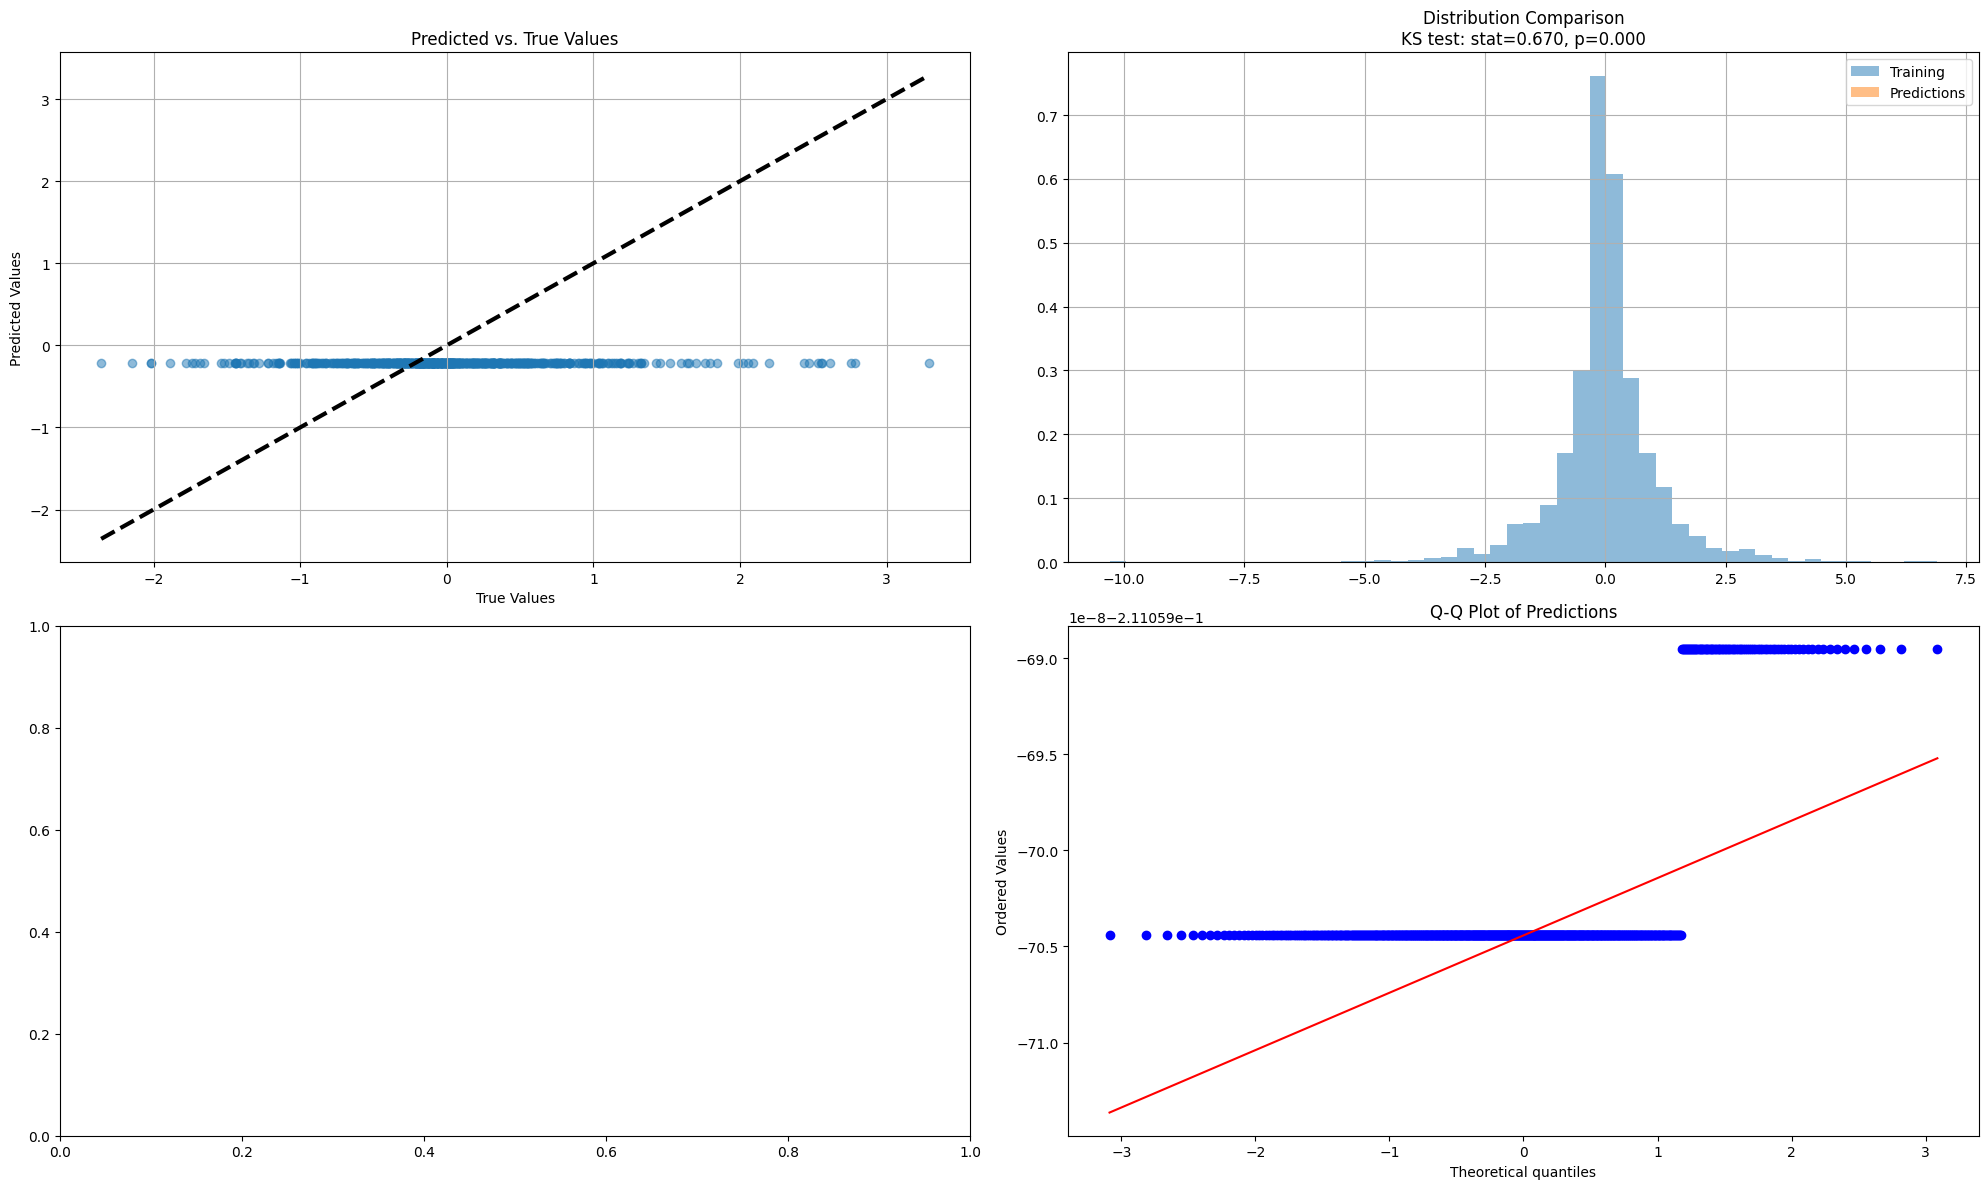

In [21]:
results = evaluate_model_with_distribution(
    best_model,
    X_test_seq,
    y_test_seq,
    train_distribution,
    None
)


Final Model Evaluation:
Test MSE: 5.5867
Test R2: -6.9968


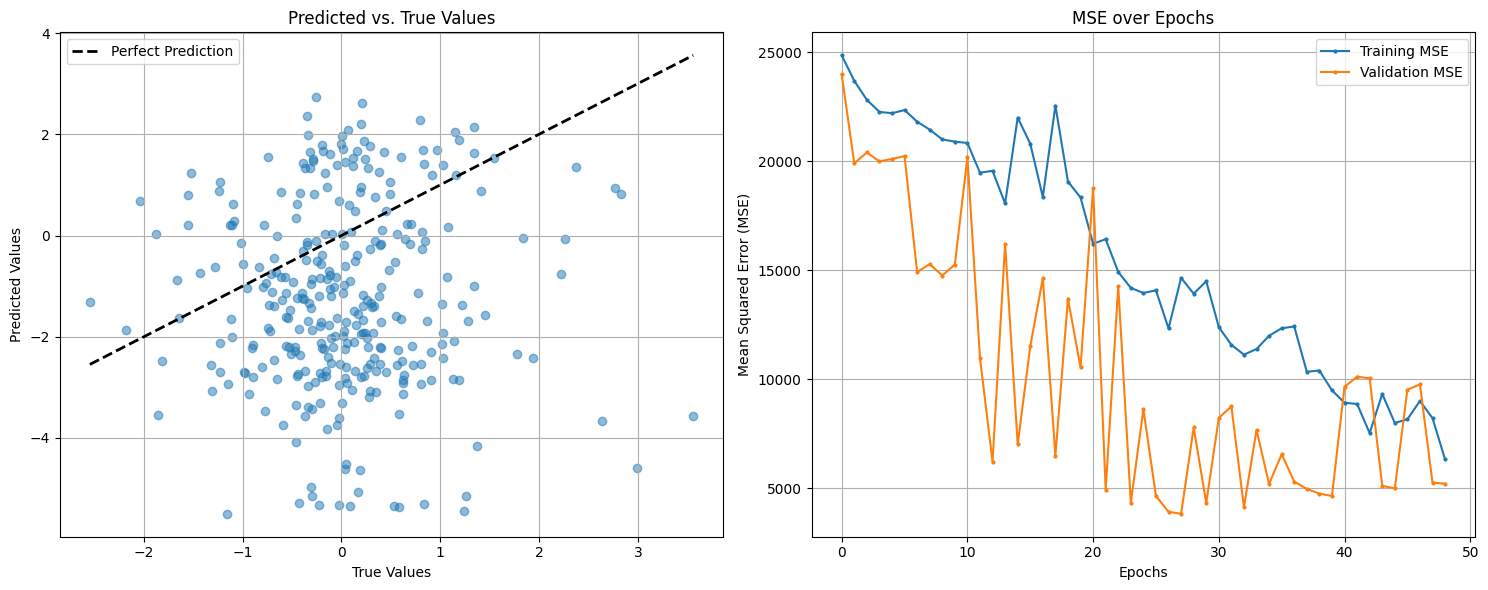


Best Hyperparameters:
batch_size: 64
dropout_rate: 0.06872244586066018
hidden_size: 64
loss_lower_bound: -1.885329972245302
loss_penalty_weight: 86474.34623534794
loss_upper_bound: 1.87789443724279
lr: 0.0002851938030758647
max_epochs: 500
nonlin: ReLU()
num_layers: 3
seq_length: 10
use_residual: True
weight_decay: 0.01040522613175178


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Get the best model and its sequence length
best_model = best_trial['result']['model']
best_seq_length = int(best_trial['result']['params']['seq_length'])

# Prepare test data with best sequence length
X_test_seq, y_test_seq = prepare_data(X_test, y_test, best_seq_length)

# Get predictions on test data
y_pred_test = best_model.predict(X_test_seq)

# Calculate metrics
test_mse = mean_squared_error(y_test_seq, y_pred_test)
test_r2 = r2_score(y_test_seq, y_pred_test)

# Print final results
print("\n" + "="*50)
print("Final Model Evaluation:")
print("="*50)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")

# Convert tensors to numpy if needed
y_pred_test = y_pred_test if isinstance(y_pred_test, np.ndarray) else y_pred_test.detach().numpy()
y_test_seq = y_test_seq if isinstance(y_test_seq, np.ndarray) else y_test_seq.detach().numpy()

# Create visualization plots
plt.figure(figsize=(15, 6))

# 1. Scatter plot of predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(y_test_seq, y_pred_test, alpha=0.5)
plt.plot([y_test_seq.min(), y_test_seq.max()],
         [y_test_seq.min(), y_test_seq.max()],
         'k--', lw=2,
         label='Perfect Prediction')
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

# 2. Training and validation loss curves
plt.subplot(1, 2, 2)
history = best_model.history
train_mse = [h['train_loss'] for h in history]
valid_mse = [h['valid_loss'] for h in history if 'valid_loss' in h]

plt.plot(train_mse, label='Training MSE', marker='o', markersize=2)
plt.plot(valid_mse, label='Validation MSE', marker='o', markersize=2)
plt.title('MSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best hyperparameters again for reference
print("\n" + "="*50)
print("Best Hyperparameters:")
print("="*50)
for param, value in best_trial['result']['params'].items():
    print(f"{param}: {value}")

# Save the best model
net = best_model

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def visualize_hyperopt_results(trials):
    """Visualize hyperopt optimization process with MSE values and log scale"""
    # Create evolution of MSE plot with log scale
    losses = [trial['result']['loss'] for trial in trials.trials]  # These are MSE values
    best_losses = np.minimum.accumulate(losses)

    # First plot: MSE evolution over trials
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=losses, name='Trial MSE',
                            mode='markers+lines', marker=dict(size=8)))
    fig.add_trace(go.Scatter(y=best_losses, name='Best MSE',
                            mode='lines', line=dict(width=2)))

    fig.update_layout(
        title='Hyperopt Optimization Progress',
        xaxis_title='Trial Number',
        yaxis_title='MSE (log scale)',
        template='plotly_white',
        yaxis_type="log"  # Set y-axis to log scale
    )
    fig.show()

    # Parameter importance visualization
    param_values = {}
    param_scores = {}

    # Collect all parameter values and scores
    for trial in trials.trials:
        for param, value in trial['result']['params'].items():
            if param not in param_values:
                param_values[param] = []
                param_scores[param] = []
            if not isinstance(value, (nn.Module, bool)):  # Skip non-numeric parameters
                param_values[param].append(float(value))
                param_scores[param].append(trial['result']['loss'])

    # Create second plot
    fig = go.Figure()

    for param in param_values.keys():
        if param_values[param]:  # Check if we have values for this parameter
            # Normalize only parameter values to 0-1 range
            param_scaler = MinMaxScaler()
            normalized_param_values = param_scaler.fit_transform(np.array(param_values[param]).reshape(-1, 1)).flatten()

            # Use actual MSE values (not normalized)
            mse_values = np.array(param_scores[param])

            fig.add_trace(go.Scatter(
                x=normalized_param_values,
                y=mse_values,  # Use actual MSE values
                mode='markers',
                name=f"{param}",
                hovertemplate=(
                    f"{param}<br>" +
                    "Normalized Value: %{x:.3f}<br>" +
                    "Original Value: %{customdata[0]:.3f}<br>" +
                    "MSE: %{y:.6f}<br>" +
                    "<extra></extra>"
                ),
                customdata=np.column_stack((
                    param_values[param],
                    mse_values
                ))
            ))

    fig.update_layout(
        title='Parameter Impact on MSE',
        xaxis_title='Normalized Parameter Value (0-1)',
        yaxis_title='MSE (log scale)',
        template='plotly_white',
        xaxis=dict(range=[-0.1, 1.1]),  # Add some padding
        yaxis_type="log"  # Set y-axis to log scale
    )

    # Add vertical reference line at x=0.5
    fig.add_vline(x=0.5, line_dash="dash", line_color="gray", opacity=0.5)

    fig.show()

# Execute the visualization
visualize_hyperopt_results(trials)
#Loog normalize these losses